**Recommender System: Multi-Model Introduction:**

This script trains a sequential recommender system on a **user-specified/customizable** MovieLens dataset (100K, 1M, 10M, or 20M).

It preprocesses the data, maps user/item IDs, and splits interactions into train/validation/test sequences.

Users can select among four models: **standard LSTM, xLSTM, BERT4REC, SAS4REC** variant with configurable parameters.

The selected model is trained using PyTorch with evaluation metrics like Recall@10, MRR, Hit Rate and NDCG.

After training, the best model is used to predict and display top-10 movie recommendations based on user history.

**Training script that integrates:**

A. Dynamic dataset selection (100K, 1M, 10M, 20M)

B. Multiple model choices (LSTM, xLSTM, BERT4Rec, SASRec)

C. Dataset-specific hyperparameters (xlstm_params, dataloader_params)

D. TensorBoard logging

E. GPU monitoring

F. Evaluation metrics (Recall@10, MRR, NDCG)

G. Early stopping + best model saving

H. Easy-readable prediction logging with movie titles


**Few Research Focus Areas/Questions:**
1. Embedding Saturation and Utilization: Are larger embeddings really helping the model learn better user/item relationships, or are they underutilized?
2. Gradient Stability / Exploding Gradients: Do longer sequences introduce more instability or gradient explosion?
3. Computation-Time vs Performance Trade-off: At what point does longer sequence input hurt speed more than it helps accuracy?
4. Effective Sequence Length vs. Truncation: How much of the input sequence is actually contributing to predictions?
5. Overfitting Signals: Do longer sequences encourage memorization rather than generalization?
6. Top-k Diversity / Coverage: Does sequence length affect recommendation diversity or item popularity bias?
7. Token Usage Heatmap: Where in the sequence is the model focusing? More recent items or early ones?
8. Ablation Logging: How much performance drop occurs when certain features are turned off?

# Initial Setup Requirements

A. Install Necessary Packages (in quite mode)

B. Triton Activation For GPU Acceleration (To make sure Triton and GPU Accerleration, to speed up the training process)

C. Select the necessary model and datasets (Model)

D. Run all would work, to change the model and datasets, please adjust the variable in the main script.

E. Script is mainly desinged for Colab Environment, for A100 GPU. Single click solution.

In [1]:
# Check the latest Python Version, not needed everytime but to ensure if any updates
import json
import urllib.request

def get_latest_version(package_name):
    url = f"https://pypi.org/pypi/{package_name}/json"
    with urllib.request.urlopen(url) as r:
        data = json.load(r)
    return data["info"]["version"]

packages = ["mlstm_kernels", "xlstm", "torch", "torchvision", "torchaudio"]
for pkg in packages:
    print(f"{pkg}: {get_latest_version(pkg)}")

mlstm_kernels: 2.0.0
xlstm: 2.0.4
torch: 2.7.1
torchvision: 0.22.1
torchaudio: 2.7.1


In [2]:
import subprocess

# List of packages with exact versions
pkgs = [
    "mlstm_kernels==2.0.0",
    "xlstm==2.0.4",
    "torch==2.7.1",
    "torchvision==0.22.1",
    "torchaudio==2.7.1"
]

# Install with CUDA 12.1 index URL and no output
subprocess.run([
    "pip", "install", "--upgrade", *pkgs,
    "--index-url", "https://download.pytorch.org/whl/cu121"
], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

print("Installed: mlstm_kernels==2.0.0, xlstm==2.0.4, torch==2.7.1, torchvision==0.22.1, torchaudio==2.7.1")

Installed: mlstm_kernels==2.0.0, xlstm==2.0.4, torch==2.7.1, torchvision==0.22.1, torchaudio==2.7.1


In [3]:
# #  Install model kernel dependencies
# !pip install -q mlstm_kernels==2.0.0 xlstm==2.0.4

# #  Install specific PyTorch + CUDA 12.1 compatible versions
# !pip install -q torch==2.7.1 torchvision==0.22.1 torchaudio==2.7.1 --index-url https://download.pytorch.org/whl/cu121

# print("[] Successfully Installed: mlstm_kernels==2.0.0, xlstm==2.0.4, torch==2.7.1, torchvision==0.22.1, torchaudio==2.7.1")

In [4]:
# PyTorch with Triton 3.1.0
# !pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [5]:
!pip install -q xlstm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.0/349.0 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [6]:
!mkdir -p /usr/local/lib
!ln -sf /usr/lib64-nvidia/libcuda.so /usr/local/lib/libcuda.so

In [7]:
!find /usr -name "build.py" | grep triton

/usr/local/lib/python3.11/dist-packages/triton/runtime/build.py


In [8]:
path = "/usr/local/lib/python3.11/dist-packages/triton/runtime/build.py"

with open(path, "r") as f:
    lines = f.readlines()

patched_lines = []
for line in lines:
    if "dirs = [" in line:
        patched_lines.append('    dirs = ["/usr/lib64-nvidia", "/usr/local/lib"]  # patched\n')
    elif "assert any(os.path.exists(" in line:
        patched_lines.append('    # assertion disabled for libcuda.so\n')
    else:
        patched_lines.append(line)

with open(path, "w") as f:
    f.writelines(patched_lines)

print("GPU Check 1: Triton 3.1.0 patched for Colab CUDA.")


GPU Check 1: Triton 3.1.0 patched for Colab CUDA.


In [9]:
import os
os.environ["TRITON_DEBUG"] = "1"
os.environ["LD_LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/lib"
os.environ["LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/lib"
os.environ["PATH"] += ":/usr/local/lib"

import triton
import triton.language as tl
import torch

@triton.jit
def add_kernel(X_ptr, Y_ptr, Z_ptr, N: tl.constexpr):
    pid = tl.program_id(0)
    if pid >= N:
        return
    x = tl.load(X_ptr + pid)
    y = tl.load(Y_ptr + pid)
    tl.store(Z_ptr + pid, x + y)

# Test kernel
size = 1024
X = torch.rand(size, device='cuda')
Y = torch.rand(size, device='cuda')
Z = torch.empty(size, device='cuda')

add_kernel[(size,)](X, Y, Z, N=size)
print(" GPU Check 2: Triton 3.x kernel executed successfully!")
print(Z[:5])

 GPU Check 2: Triton 3.x kernel executed successfully!
tensor([0.2231, 0.9894, 1.2907, 1.0191, 0.5202], device='cuda:0')


In [10]:
#Just in case of Error:
# import os
# os.kill(os.getpid(), 9)

Model Selection Here:

In [16]:
MOVIELENS_VERSION = "10M"  # Choose from "100K","1M","10M","20M"
MODEL_SELECTION = "BERT4Rec"  # "LSTM", "xLSTM", "BERT4Rec", "SAS4Rec"
EPOCHS = 10
MAX_LEN = 100

#early stopping
patience = 3
# Run the Main Script after selection

In [19]:
# Main Script
def recommender_main():
        import os, sys, zipfile, requests, threading, subprocess, time, random, warnings
        import pandas as pd, numpy as np
        import torch, torch.nn as nn, torch.optim as optim
        from torch.utils.data import Dataset, DataLoader
        from torch.utils.tensorboard import SummaryWriter
        from tqdm import tqdm
        import matplotlib.pyplot as plt
        from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge

        warnings.filterwarnings("ignore")

        # BATCH_SIZE = 256
        LEARNING_RATE = 1e-3

        os.environ["TRITON_DEBUG"] = "1"
        print("Output Section 1: Initialization")
        print("[INFO] Model initialized. Triton should log kernel compilation now.")

        # import os
        # # Required for Triton to run correctly in Colab
        # os.environ["TRITON_DEBUG"] = "1"
        os.environ["LD_LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/lib"
        os.environ["LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/lib"
        os.environ["PATH"] += ":/usr/local/lib"

        start_time = time.time()

        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        import threading
        import subprocess
        import time

        gpu_utilization_log = []
        gpu_memory_log = []
        gpu_time_log = []


        def monitor_gpu(writer=None, interval=60):
            while True:
                output = subprocess.getoutput(
                    "nvidia-smi --query-gpu=utilization.gpu,memory.used --format=csv,noheader,nounits"
                )
                util, mem = map(int, output.strip().split(','))
                elapsed = time.time() - start_time

                gpu_utilization_log.append(util)
                gpu_memory_log.append(mem)
                gpu_time_log.append(elapsed)

                print(f"[GPU MONITOR] {util}% GPU, {mem} MiB")

                # 🔥 TensorBoard logging
                if writer:
                    writer.add_scalar("GPU/Utilization(%)", util, global_step=int(elapsed))
                    writer.add_scalar("GPU/Memory(MiB)", mem, global_step=int(elapsed))

                time.sleep(interval)


        # Start GPU monitor thread
        # monitor_thread = threading.Thread(target=monitor_gpu, daemon=True)
        # monitor_thread = threading.Thread(target=monitor_gpu, args=(120,), daemon=True)

        # monitor_thread.start()

        train_seqs = {}
        val_seqs = {}
        test_seqs = {}

        step_counter = 1
        logged_users = set()
        max_print_users = 5
        log_lines = []
        log_file_path = "training_logs.txt"


        sys.path.append("../..")


        # -----------------------------
        # 1. Select MovieLens Dataset
        # -----------------------------

        dataset_urls = {
            "100K": "https://files.grouplens.org/datasets/movielens/ml-100k.zip",
            "1M": "https://files.grouplens.org/datasets/movielens/ml-1m.zip",
            "10M": "https://files.grouplens.org/datasets/movielens/ml-10m.zip",
            "20M": "https://files.grouplens.org/datasets/movielens/ml-20m.zip"
        }

        dataset_dirs = {
            "100K": "ml-100k",
            "1M": "ml-1m",
            "10M": "ml-10M100K",
            "20M": "ml-20m"
        }

        xlstm_params = {
            "100K": {"embedding_dim": 64, "num_heads": 2, "num_blocks": 1},
            "1M": {"embedding_dim": 128, "num_heads": 2, "num_blocks": 2},
            "10M": {"embedding_dim": 256, "num_heads": 8, "num_blocks": 4},
            "20M": {"embedding_dim": 256, "num_heads": 8, "num_blocks": 4}
        }

        dataloader_params = {
            "100K": {"batch_size": 128, "num_workers": 2},
            "1M": {"batch_size": 128, "num_workers": 2},
            "10M": {"batch_size": 3072, "num_workers": 8},
            "20M": {"batch_size": 3072, "num_workers": 4}
        }

        # xlstm_params = {
        #     "100K": {"embedding_dim": 64, "num_heads": 2, "num_blocks": 1},
        #     "1M": {"embedding_dim": 96, "num_heads": 2, "num_blocks": 2},
        #     "10M": {"embedding_dim": 128, "num_heads": 2, "num_blocks": 2},
        #     "20M": {"embedding_dim": 256, "num_heads": 8, "num_blocks": 4}
        # }

        # dataloader_params = {
        #     "100K": {"batch_size": 128, "num_workers": 2},
        #     "1M": {"batch_size": 128, "num_workers": 2},
        #     "10M": {"batch_size": 1024, "num_workers": 2},
        #     "20M": {"batch_size": 1024, "num_workers": 2}
        # }

        # dataloader_params = {
        #     "100K": {"batch_size": 128, "num_workers": 2},
        #     "1M": {"batch_size": 256, "num_workers": 2},
        #     "10M": {"batch_size": 1024, "num_workers": 2},
        #     "20M": {"batch_size": 1024, "num_workers": 2}
        # }


        # ------------------------------
        # TensorBoard
        # ------------------------------
        # log_dir = f"runs/{MODEL_SELECTION}_{MOVIELENS_VERSION}_{EPOCHS}_{int(time.time())}"
        params = xlstm_params[MOVIELENS_VERSION]  # dynamically get config

        log_dir = f"runs/{MODEL_SELECTION}_{MOVIELENS_VERSION}_SL:{MAX_LEN}_Emb:{params['embedding_dim']}"

        writer = SummaryWriter(log_dir=log_dir)

        monitor_thread = threading.Thread(target=monitor_gpu, args=(writer, 60), daemon=True)
        monitor_thread.start()


        DATA_URL = dataset_urls[MOVIELENS_VERSION]
        DATA_DIR = dataset_dirs[MOVIELENS_VERSION]

        if not os.path.exists(DATA_DIR):
            print(f"Downloading MovieLens {MOVIELENS_VERSION} dataset...")
            r = requests.get(DATA_URL)
            zip_filename = f"{DATA_DIR}.zip"
            with open(zip_filename, "wb") as f:
                f.write(r.content)
            with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                zip_ref.extractall(".")
            print("Extraction complete.")

        # -----------------------------
        # 2. Load and Preprocess Data
        # -----------------------------
        if MOVIELENS_VERSION == "100K":
            rating_df = pd.read_csv(os.path.join(DATA_DIR, "u.data"), sep="\t", engine='python',
                                    names=['user_id', 'movie_id', 'rating', 'timestamp'])
            movies = pd.read_csv(os.path.join(DATA_DIR, "u.item"), sep='|', encoding='latin-1', header=None, engine='python',
                                names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                                        'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                                        'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                                        'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
            users = pd.read_csv(os.path.join(DATA_DIR, "u.user"), sep='|', header=None,
                                names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

        elif MOVIELENS_VERSION == "1M":
            rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.dat"), sep="::", engine='python',
                                    names=['user_id', 'movie_id', 'rating', 'timestamp'])
            movies = pd.read_csv(os.path.join(DATA_DIR, "movies.dat"), sep="::", engine='python',
                                names=['movie_id', 'title', 'genres'], encoding='latin-1')
            users = pd.read_csv(os.path.join(DATA_DIR, "users.dat"), sep="::", engine='python',
                                names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])

        elif MOVIELENS_VERSION == "10M":
            rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.dat"), sep="::", engine='python',
                                    names=['user_id', 'movie_id', 'rating', 'timestamp'])
            movies = pd.read_csv(os.path.join(DATA_DIR, "movies.dat"), sep="::", engine='python',
                                names=['movie_id', 'title', 'genres'], encoding='latin-1')
            users = pd.DataFrame({'user_id': rating_df['user_id'].unique()})  # No user metadata

        elif MOVIELENS_VERSION == "20M":
            rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.csv"))
            movies = pd.read_csv(os.path.join(DATA_DIR, "movies.csv"))
            users = pd.DataFrame({'user_id': rating_df['userId'].unique()})  # No user metadata

            rating_df.rename(columns={'userId': 'user_id', 'movieId': 'movie_id'}, inplace=True)
            movies.rename(columns={'movieId': 'movie_id'}, inplace=True)

        # -----------------------------
        # Map User and Item IDs
        # -----------------------------
        rating_df.sort_values(by=['user_id', 'timestamp'], inplace=True)
        user2id = {uid: i for i, uid in enumerate(rating_df['user_id'].unique())}
        item2id = {iid: i for i, iid in enumerate(rating_df['movie_id'].unique())}
        rating_df['user_id'] = rating_df['user_id'].map(user2id)
        rating_df['movie_id'] = rating_df['movie_id'].map(item2id)

        movie_titles = {item2id[row['movie_id']]: row['title'] for _, row in movies.iterrows() if row['movie_id'] in item2id}

        if 'user_id' in users.columns:
            users['user_id'] = users['user_id'].map(user2id)
            users.dropna(subset=['user_id'], inplace=True)
            users['user_id'] = users['user_id'].astype(int)

        if 'movie_id' in movies.columns:
            movies['movie_id'] = movies['movie_id'].map(item2id)
            movies.dropna(subset=['movie_id'], inplace=True)
            movies['movie_id'] = movies['movie_id'].astype(int)

        rating_df = rating_df.merge(users, on='user_id', how='left')
        rating_df = rating_df.merge(movies, on='movie_id', how='left')

        num_users = len(user2id)
        num_items = len(item2id)

        print("-------------------------")
        print("Output Section 2: Important Parameters and Model Selection")

        print(f"Model: {MODEL_SELECTION}")
        print(f"Dataset: {MOVIELENS_VERSION}")
        print(f"MAX_LEN: {MAX_LEN}, LEARNING_RATE: {LEARNING_RATE}")

        #print(f"MAX_LEN: {MAX_LEN}, BATCH_SIZE: {batch_size}, LEARNING_RATE: {LEARNING_RATE}")
        print(f"Model Params ({MOVIELENS_VERSION}): {xlstm_params[MOVIELENS_VERSION]}")
        print(f"Dataloader Params ({MOVIELENS_VERSION}): {dataloader_params[MOVIELENS_VERSION]}")

        print(f"Length of ratings: {len(rating_df)}")
        print(f"Shape: {rating_df.shape}")
        print(f"Num users: {num_users}, Num items: {num_items}")

        print(f"Length of the ratings: {len(rating_df)}")
        print(f"Shape of the ratings dataframe: {rating_df.shape}")

        print("-------------------------")
        print("                  ")
        print("Output Section 3: Input Datasets For Reference")

        print(rating_df.head())
        # print(user2id)
        print(f"Number of unique users: {num_users}")
        print(f"Number of unique items: {num_items}")

        user_interactions = rating_df.groupby('user_id')['movie_id'].count()

        # Average sequence length (i.e., avg number of interactions per user)
        avg_seq_len = user_interactions.mean()

        # Sparsity calculation
        total_possible_interactions = num_users * num_items
        actual_interactions = len(rating_df)
        sparsity = 1.0 - (actual_interactions / total_possible_interactions)

        # Print the results
        print(f"\n[INFO] Additional Dataset Statistics:")
        print(f"Average sequence length: {avg_seq_len:.2f}")
        print(f"Sparsity score: {sparsity * 100:.2f}%")

        # -----------------------------
        # Step 1: Build Feature Dictionaries
        # -----------------------------
        genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                        'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                        'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

        # -----------------------------
        # Step 2: Construct Sequence Splits
        # -----------------------------


        MIN_CONTEXT = 5


        for uid, group in rating_df.groupby('user_id'):
            items = group['movie_id'].tolist()

            if len(items) <= MIN_CONTEXT + 2:
                continue

            # Disjoint splits
            train_items = items[:-2]
            val_item = items[-2]
            test_item = items[-1]

            # Floating training (allowed)
            train_seqs[uid] = train_items

            # Fixed validation: only predict next item once
            val_seqs[uid] = [(train_items, val_item)]

            # Fixed test: only predict the final item
            test_seqs[uid] = [(train_items + [val_item], test_item)]

        # -----------------------------
        # Step 3: Dataset Classes
        # -----------------------------
        class TrainDataset(Dataset):
            def __init__(self, sequences, max_len=MAX_LEN):
                self.samples = []
                for uid, items in sequences.items():
                    for i in range(1, len(items)):
                        seq = items[max(0, i - max_len):i]
                        target = items[i]
                        self.samples.append((seq, target))
                self.max_len = max_len
                print(f"Train samples: {len(self.samples)}")

            def __len__(self):
                return len(self.samples)

            def __getitem__(self, idx):
                seq, target = self.samples[idx]
                padded_seq = [0] * (self.max_len - len(seq)) + seq
                # seq_features = [movie_feat_dict.get(mid, np.zeros(feature_dim)) for mid in padded_seq]
                # target_feat = movie_feat_dict.get(target, np.zeros(feature_dim))
                return torch.tensor(padded_seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

        class TestDataset(Dataset):
            def __init__(self, sequences, max_len=MAX_LEN):
                self.samples = []
                for uid, pairs in sequences.items():
                    for seq, tgt in pairs:
                        seq = seq[-max_len:]
                        self.samples.append((seq, tgt))
                self.max_len = max_len

            def __len__(self):
                return len(self.samples)

            def __getitem__(self, idx):
                seq, target = self.samples[idx]
                padded_seq = [0] * (self.max_len - len(seq)) + seq
                # seq_features = [movie_feat_dict.get(mid, np.zeros(feature_dim)) for mid in padded_seq]
                # target_feat = movie_feat_dict.get(target, np.zeros(feature_dim))
                return torch.tensor(padded_seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

        class EvalDataset(Dataset):
            def __init__(self, sequences, max_len=MAX_LEN):
                self.samples = []
                for uid, pairs in sequences.items():
                    for seq, tgt in pairs:
                        seq = seq[-max_len:]
                        self.samples.append((uid, seq, tgt))
                self.max_len = max_len

            def __len__(self):
                return len(self.samples)

            def __getitem__(self, idx):
                uid, seq, target = self.samples[idx]
                padded_seq = [0] * (self.max_len - len(seq)) + seq
                # seq_features = [movie_feat_dict.get(mid, np.zeros(feature_dim)) for mid in padded_seq]
                # target_feat = movie_feat_dict.get(target, np.zeros(feature_dim))
                return torch.tensor(padded_seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

        # -----------------------------
        # Inspect train/val/test sequences
        # -----------------------------

        train_dataset = TrainDataset(train_seqs)

        seq, target = train_dataset[0]
        print("")
        print("--------------------")
        print("Output Section 4: Input Model Format References")
        print("\n[DEBUG] Input sequence shape:", seq.shape)
        print("[DEBUG] Example feature vector at t=0:", seq[0])
        print("[DEBUG] Target vector:", target)


        print("\n[INFO] Sample from train_seqs:")
        for uid in list(train_seqs.keys())[0:4]:  # Show 3 users (UIDs 1 to 3)
            print(f"\nUser ID: {uid}")
            print(f"Train sequence (movie_ids): {train_seqs[uid]}")
            print(f"Sequence length: {len(train_seqs[uid])}")

        print("\n[INFO] Sample from val_seqs:")
        for uid in list(val_seqs.keys())[0:4]:  # Show 3 users (UIDs 1 to 3)
            print(f"\nUser ID: {uid}")
            print("Validation samples (prefix -> target):")
            for prefix, target in val_seqs[uid][:3]:  # Show first 3 (prefix, target) pairs
                print(f"  {prefix} -> {target}")

        print("\n[INFO] Sample from test_seqs:")
        for uid in list(test_seqs.keys())[0:4]:  # Show 3 users (UIDs 1 to 3)
            print(f"\nUser ID: {uid}")
            prefix, target = test_seqs[uid][0]  # Only one test pair per user
            print(f"Test prefix: {prefix}")
            print(f"Test target: {target}")


        # -----------------------------
        # Step 4: DataLoaders
        # -----------------------------

        dl_params = dataloader_params[MOVIELENS_VERSION]

        train_loader = DataLoader(
            TrainDataset(train_seqs),
            batch_size=dl_params["batch_size"],
            shuffle=True,
            num_workers=dl_params["num_workers"]
        )

        val_loader = DataLoader(
            EvalDataset(val_seqs),
            batch_size=dl_params["batch_size"],
            num_workers=dl_params["num_workers"]
        )

        test_loader = DataLoader(
            EvalDataset(test_seqs),
            batch_size=dl_params["batch_size"],
            num_workers=dl_params["num_workers"]
        )



        inputs, targets = next(iter(train_loader))

        print("[DEBUG] Input batch shape:", inputs.shape)    # (batch_size, max_len, feature_dim)
        print("[DEBUG] Target batch shape:", targets.shape)  # (batch_size, feature_dim)

        # Optional: print first sample
        print("[DEBUG] First input sequence shape:", inputs[0].shape)
        print("[DEBUG] First target vector:", targets[0])

        # -----------------------------
        # 4. Model Setup
        # -----------------------------

        # params = xlstm_params[MOVIELENS_VERSION]  # dynamically get config

        print(f"[DEBUG] max value in all input sequences: {max([max(seq) for seq in train_seqs.values()])}")
        print(f"[DEBUG] num_items: {num_items}")


        if MODEL_SELECTION == "LSTM":
            class LSTMModel(nn.Module):
                def __init__(self, num_items, embedding_dim, hidden_dim, num_layers):
                    super().__init__()
                    self.embedding = nn.Embedding(num_items, embedding_dim)
                    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
                    self.output_layer = nn.Linear(hidden_dim, num_items)

                def forward(self, x):
                    x = self.embedding(x)
                    out, _ = self.lstm(x)
                    out = out[:, -1, :]
                    logits = self.output_layer(out)
                    return logits

            model = LSTMModel(
                num_items=num_items,
                embedding_dim=params["embedding_dim"],
                hidden_dim=params["embedding_dim"],  # You can make this separate if desired
                num_layers=1
            )

        elif MODEL_SELECTION == "BERT4Rec":
            from transformers import BertModel, BertConfig
            class BERT4RecModel(nn.Module):
                def __init__(self, num_items, params, max_len=MAX_LEN):
                    super().__init__()
                    config = BertConfig(
                        vocab_size=num_items + 1,
                        hidden_size=params["embedding_dim"],
                        num_hidden_layers=params["num_blocks"],
                        num_attention_heads=params["num_heads"],
                        intermediate_size=params["embedding_dim"] * 4,
                        max_position_embeddings=max_len + 2,
                        hidden_dropout_prob=0.1,
                        attention_probs_dropout_prob=0.1
                    )
                    self.bert = BertModel(config)
                    self.output_layer = nn.Linear(config.hidden_size, num_items + 1)
                def forward(self, x):
                    # out = self.bert(input_ids=x).last_hidden_state
                    attention_mask = (x != 0).long()
                    out = self.bert(input_ids=x, attention_mask=attention_mask).last_hidden_state
                    return self.output_layer(out[:, -1, :])
            model = BERT4RecModel(num_items=num_items,params=params,max_len=MAX_LEN)

        elif MODEL_SELECTION == "SAS4Rec":
              class SASRecModel(nn.Module):
                  def __init__(self, num_items, hidden_dim, max_len, num_heads, num_blocks):
                      super().__init__()
                      self.item_embedding = nn.Embedding(num_items + 1, hidden_dim, padding_idx=0)
                      self.pos_embedding = nn.Embedding(max_len, hidden_dim)
                      self.attention_blocks = nn.ModuleList([
                          nn.TransformerEncoderLayer(
                              d_model=hidden_dim,
                              nhead=num_heads,
                              dim_feedforward=hidden_dim * 4,
                              dropout=0.1,
                              batch_first=True
                          ) for _ in range(num_blocks)
                      ])
                      self.output_layer = nn.Linear(hidden_dim, num_items + 1)
                      self.max_len = max_len

                  def forward(self, x):
                      positions = torch.arange(x.size(1), device=x.device).unsqueeze(0)
                      x = self.item_embedding(x) + self.pos_embedding(positions)

                      # Causal mask to block future tokens
                      attn_mask = torch.triu(torch.ones(x.size(1), x.size(1), device=x.device), diagonal=1).bool()

                      for block in self.attention_blocks:
                          x = block(x, src_mask=attn_mask)

                      return self.output_layer(x[:, -1, :])

              # model = SASRecModel(num_items=num_items,params=params,max_len=MAX_LEN)
              model = SASRecModel(num_items, params["embedding_dim"], MAX_LEN, params["num_heads"], params["num_blocks"])



        elif MODEL_SELECTION == "xLSTM":
            xlstm_config = xLSTMLargeConfig(
                embedding_dim=params["embedding_dim"],
                num_heads=params["num_heads"],
                num_blocks=params["num_blocks"],
                vocab_size=num_items + 1,
                return_last_states=True,
                mode="inference",
                chunkwise_kernel="chunkwise--triton_xl_chunk",
                sequence_kernel="native_sequence__triton",
                step_kernel="triton",
            )
            model = xLSTMLarge(xlstm_config)

        else:  # xLSTM (default)
            raise ValueError(f"Unknown MODEL_SELECTION: {MODEL_SELECTION}")

        # model = torch.compile(model)
        # model = torch.compile(model, fullgraph=True, dynamic=False)


        # print(f"[SANITY] model embedding size: {xlstm_config.vocab_size}")

        if MODEL_SELECTION in ["xLSTM", "xLSTMLarge"]:
            print(f"[SANITY] model embedding size: {xlstm_config.vocab_size}")
        elif MODEL_SELECTION == "SAS4Rec":
            print(f"[SANITY] model embedding size: {model.item_embedding.num_embeddings}")
        elif MODEL_SELECTION == "BERT4Rec":
            print(f"[SANITY] BERT vocab size: {model.bert.config.vocab_size}")
        elif MODEL_SELECTION == "LSTM":
            print(f"[SANITY] model embedding size: {model.embedding.num_embeddings}")
        print(f"[SANITY] highest input ID: {inputs.max().item()}")

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # 🔧 Set up training components
        criterion = nn.CrossEntropyLoss()
        # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # model.to(device)

        # 🔢 Count and log total trainable parameters
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"[INFO] Total trainable parameters: {total_params}")
        writer.add_scalar("Model/TotalParams", total_params, 0)


        # criterion = nn.CrossEntropyLoss()

        optimizer = optim.Adam(model.parameters(), lr=0.001)
        recall_list, mrr_list, ndcg_list, loss_list, hit_rate_list = [], [], [], [], []

        best_recall = 0.0
        # save_path = f"best_model_{MOVIELENS_VERSION}.pt"
        save_path = f"best_model_{MOVIELENS_VERSION}_{MODEL_SELECTION}_SL:{MAX_LEN}_Emb:{params['embedding_dim']}.pt"

        print("")
        print("--------------------")
        print("Output Section 5: GPU References")

        print(f"\nCheck 1: Using device: {device}")
        if device.type == 'cuda':
            print(f"GPU: {torch.cuda.get_device_name(0)}")
            print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

        # -----------------------------
        # 5. Metrics
        # -----------------------------

        def recall_mrr_ndcg_k(preds, targets, k=10):
            hit_count = 0
            recall, mrr, ndcg = 0.0, 0.0, 0.0
            total_preds = len(preds)

            for pred, target in zip(preds, targets):
                top_k = pred[:k]
                if target in top_k:
                    hit_count += 1
                    rank = top_k.index(target)
                    recall += 1
                    mrr += 1.0 / (rank + 1)
                    ndcg += 1.0 / np.log2(rank + 2)

            hit_rate = hit_count / total_preds if total_preds > 0 else 0.0
            recall = recall / total_preds if total_preds > 0 else 0.0
            mrr = mrr / total_preds if total_preds > 0 else 0.0
            ndcg = ndcg / total_preds if total_preds > 0 else 0.0

            return hit_rate, recall, mrr, ndcg, hit_count, total_preds


        # -----------------------------
        # 6. Training
        # -----------------------------
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        recall_list, mrr_list, ndcg_list = [], [], []


        epochs_no_improve = 0

        gpu_info = !nvidia-smi
        gpu_info = '\n'.join(gpu_info)
        if gpu_info.find('failed') >= 0:
          print('Not connected to a GPU')
        else:
          print(gpu_info)

        print("")
        print("--------------------")
        print("Output Section 6: Model Training")

        print("\nStarting training...")
        for epoch in range(EPOCHS):
            epoch_start_time = time.time()
            model.train()
            total_loss = 0
            for seqs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
                seqs, targets = seqs.to(device), targets.to(device)
                optimizer.zero_grad()

                # Edit 1:
                # logits = model(seqs)[0]
                # if logits.dim() == 3:
                #     logits = logits[:, -1, :]
                # loss = criterion(logits, targets)

                #Edit 2:
                # logits = model(seqs)  # output shape: [B, T, V]
                # if logits.dim() == 3:
                #     logits = logits[:, -1, :]  # final time step
                # targets = targets  # shape: [B]
                # # print("logits shape:", logits.shape)
                # # print("targets shape:", targets.shape)
                # loss = criterion(logits, targets)

                logits = model(seqs)
                if isinstance(logits, tuple):
                    logits = logits[0]  # extract logits from tuple

                if logits.dim() == 3:
                    logits = logits[:, -1, :]  # shape: [B, V]
                logits = torch.clamp(logits, min=-30, max=30)

                # Targets assumed to be shape [B] (index of next item)
                loss = criterion(logits, targets)

                #loss = criterion(logits, targets)

                # Compute predictions
                #top_preds = torch.topk(logits, k=1, dim=-1).indices.squeeze(1)  # shape: [B]

                top_preds = torch.topk(logits, k=1, dim=-1).indices.squeeze(1)
                top_10_preds = torch.topk(logits, k=10, dim=-1).indices  # shape [B, 10]

                DEBUG_LOGGING = False  # ✅ set to True only for debugging first few batches

                if DEBUG_LOGGING:
                    for b in range(seqs.size(0)):
                        context_seq = seqs[b].tolist()
                        target_item = targets[b].item()
                        pred_item = top_preds[b].item()
                        top_10_items = top_10_preds[b].tolist()
                        loss_value = nn.functional.cross_entropy(
                            logits[b].unsqueeze(0), targets[b].unsqueeze(0)
                        ).item()
                        status = "Valid" if pred_item == target_item else "InValid"
                        trimmed_seq = [i for i in context_seq if i > 0]
                        user_hash = hash(tuple(trimmed_seq))

                        sorted_logits = torch.argsort(logits[b], descending=True)
                        try:
                            rank = sorted_logits.tolist().index(target_item) + 1
                        except ValueError:
                            rank = -1

                        log_line = (
                            f"Step = {step_counter}, User: {user_hash}, "
                            f"Training Seq = {trimmed_seq}, "
                            f"Target = [{target_item}], Pred = [{pred_item}], "
                            f"Status = \"{status}\", Loss = [{loss_value:.4f}], "
                            f"Recall@10 = {top_10_items}, Rank = [{rank}]"
                        )
                        log_lines.append(log_line)

                        if user_hash not in logged_users and len(logged_users) < max_print_users:
                            print(log_line)
                            logged_users.add(user_hash)

                        step_counter += 1


                loss.backward()

                # Gradient Norm
                total_norm = 0
                for p in model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                total_norm = total_norm ** 0.5
                writer.add_scalar("GradientNorm", total_norm, epoch)


                optimizer.step()
                total_loss += loss.item()


            # Evaluate on test set
            model.eval()
            all_preds, all_targets = [], []

            with torch.no_grad():
                for seqs, targets in val_loader:
                    seqs = seqs.to(device)
                    logits = model(seqs)
                    if isinstance(logits, tuple):
                        logits = logits[0]
                    if logits.dim() == 3:
                        logits = logits[:, -1, :]
                    topk = torch.topk(logits, k=10, dim=-1).indices.cpu().tolist()
                    all_preds.extend(topk)
                    all_targets.extend(targets.tolist())

            hit_rate, recall, mrr, ndcg, correct_hits, total_preds = recall_mrr_ndcg_k(all_preds, all_targets)

            #recall, mrr, ndcg = recall_mrr_ndcg_k(all_preds, all_targets)
            recall_list.append(recall)
            mrr_list.append(mrr)
            ndcg_list.append(ndcg)
            hit_rate_list.append(hit_rate)
            loss_list.append(total_loss)

            #print(f"Epoch {epoch+1} | Loss: {total_loss:.2f} | Recall@10: {recall:.4f} | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")
            # print(f"Epoch {epoch+1} | Loss: {total_loss:.2f} | Recall@10: {recall:.4f} "
            #   f"({correct_hits}/{total_preds}) | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")

            print(f"Epoch {epoch+1} | Loss: {total_loss:.2f} | "
                  f"HR@10: {hit_rate:.4f} ({correct_hits}/{total_preds}) | "
                  f"Recall@10: {recall:.4f} | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")

            epoch_time = time.time() - epoch_start_time
            writer.add_scalar("EpochTime", epoch_time, epoch)

            writer.add_scalar("HitRate@10/test", hit_rate, epoch)
            writer.add_scalar("Loss/train", total_loss, epoch)
            writer.add_scalar("Recall@10/test", recall, epoch)
            writer.add_scalar("MRR@10/test", mrr, epoch)
            writer.add_scalar("NDCG@10/test", ndcg, epoch)
            writer.add_scalar("LearningRate", optimizer.param_groups[0]['lr'], epoch)



            if recall > best_recall:
                best_recall = recall
                torch.save(model.state_dict(), save_path)
                print(f"Saved new best model (Recall@10 = {recall:.4f}) to {save_path}")
                epochs_no_improve = 0  # reset on improvement
            else:
                epochs_no_improve += 1
                print(f" Alert for Early Stopping: No improvement for {epochs_no_improve} epoch(s)")

            if epochs_no_improve >= patience:
                print(f"\n Early stopping triggered. For {patience} consecutive epochs. Best Model has been saved successfully")
                break

        print(f"\n Loading best model from: {save_path}")
        model.load_state_dict(torch.load(save_path, map_location=device))
        model.to(device)
        model.eval()
        # -----------------------------
        # 7. Plot
        # -----------------------------

        print("")
        print("--------------------")
        print("Output Section 6: Performance Metrics")

        plt.figure()
        plt.plot(recall_list, label='Recall@10')
        plt.plot(mrr_list, label='MRR@10')
        plt.plot(ndcg_list, label='NDCG@10')
        plt.plot(hit_rate_list, label='HitRate@10')
        plt.xlabel('Epoch')
        plt.ylabel('Metric')
        plt.title('Test Metrics Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()


        plt.figure()
        plt.plot(loss_list, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.grid(True)
        plt.legend()
        plt.show()


        elapsed_minutes = (time.time() - start_time) / 60
        print(f"\nTotal run time: {elapsed_minutes:.2f} minutes")

        print("")
        print("--------------------")
        print("Output Section 7: Sample Predictions")

        # -----------------------------
        # 8. Sample Predictions
        # -----------------------------
        sample_dataset = EvalDataset(test_seqs, max_len=MAX_LEN)
        sample_loader = DataLoader(sample_dataset, batch_size=1, shuffle=True)


        with torch.no_grad():
            for i, (seq_tensor, target_tensor) in enumerate(sample_loader):
                # uid = uid_tensor.item()
                input_seq = seq_tensor.to(device)
                target = target_tensor.item()

                logits = model(input_seq)[0]
                if logits.dim() == 3:
                    logits = logits[:, -1, :]

                probs = torch.softmax(logits, dim=-1)
                topk_logits = torch.topk(logits, k=10, dim=-1)
                topk_probs = torch.topk(probs, k=10, dim=-1)

                topk_items = topk_probs.indices.squeeze().tolist()
                topk_scores = topk_probs.values.squeeze().tolist()
                topk_raw_logits = topk_logits.values.squeeze().tolist()

                input_ids = seq_tensor.squeeze().tolist()
                print(f"\nUser ID: {uid}")
                print("Input sequence:")
                for m in input_ids:
                    if m > 0:
                        print(f"  - Item {m}: {movie_titles.get(m, 'Unknown')}")

                true_movie = movie_titles.get(target, f"Item {target}")
                # true_prob = probs[0, target].item()
                # true_logit = logits[0, target].item()
                true_prob = probs.view(-1)[target].item()
                true_logit = logits.view(-1)[target].item()

                print(f"True next item: Item {target}: {true_movie} (logit: {true_logit:.4f}, confidence: {true_prob:.4f})")

                print("Top-10 Predictions with scores:")
                for rank, (item, logit_score, prob_score) in enumerate(zip(topk_items, topk_raw_logits, topk_scores), start=1):
                    movie_name = movie_titles.get(item, f"Item {item}")
                    print(f"  {rank}. Item {item}: {movie_name} (logit: {logit_score:.4f}, confidence: {prob_score:.4f})")

                if i == 4:
                    break

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(gpu_time_log, gpu_utilization_log)
        plt.title("GPU Utilization Over Time")
        plt.xlabel("Time (s)")
        plt.ylabel("Utilization (%)")
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(gpu_time_log, gpu_memory_log)
        plt.title("GPU Memory Usage Over Time")
        plt.xlabel("Time (s)")
        plt.ylabel("Memory (MiB)")
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        writer.close()

        print(f"\n Loading best model from: {save_path} {MOVIELENS_VERSION}{MODEL_SELECTION}")
        print("Completed")

Output Section 1: Initialization
[INFO] Model initialized. Triton should log kernel compilation now.
[GPU MONITOR] 0% GPU, 21309 MiB
[GPU MONITOR] 0% GPU, 21309 MiB
-------------------------
Output Section 2: Important Parameters and Model Selection
Model: BERT4Rec
Dataset: 10M
MAX_LEN: 100, LEARNING_RATE: 0.001
Model Params (10M): {'embedding_dim': 256, 'num_heads': 8, 'num_blocks': 4}
Dataloader Params (10M): {'batch_size': 3072, 'num_workers': 8}
Length of ratings: 10000054
Shape: (10000054, 6)
Num users: 69878, Num items: 10677
Length of the ratings: 10000054
Shape of the ratings dataframe: (10000054, 6)
-------------------------
                  
Output Section 3: Input Datasets For Reference
   user_id  movie_id  rating  timestamp                          title  \
0        0         0     5.0  838983339                 Aladdin (1992)   
1        0         1     5.0  838983392           Dumb & Dumber (1994)   
2        0         2     5.0  838983392                Stargate (1994)

Epoch 1:   0%|          | 0/3187 [00:00<?, ?it/s]

[GPU MONITOR] 0% GPU, 21309 MiB


Epoch 1:   1%|          | 39/3187 [00:23<26:29,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB[GPU MONITOR] 100% GPU, 30611 MiB



Epoch 1:   3%|▎         | 107/3187 [00:57<25:55,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:   4%|▎         | 117/3187 [01:02<25:50,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:   5%|▍         | 158/3187 [01:23<25:29,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:   7%|▋         | 226/3187 [01:57<24:54,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:   7%|▋         | 236/3187 [02:02<24:49,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:   9%|▊         | 277/3187 [02:23<24:28,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  11%|█         | 345/3187 [02:58<23:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  11%|█         | 355/3187 [03:03<23:50,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  12%|█▏        | 396/3187 [03:23<23:29,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  15%|█▍        | 464/3187 [03:58<22:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  15%|█▍        | 473/3187 [04:02<22:52,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  16%|█▌        | 514/3187 [04:23<22:31,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  18%|█▊        | 583/3187 [04:58<21:56,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  19%|█▊        | 592/3187 [05:02<21:51,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  20%|█▉        | 633/3187 [05:23<21:30,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  22%|██▏       | 701/3187 [05:57<20:55,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 1:  22%|██▏       | 711/3187 [06:02<20:50,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  24%|██▎       | 752/3187 [06:23<20:30,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  26%|██▌       | 820/3187 [06:57<19:55,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  26%|██▌       | 830/3187 [07:03<19:50,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  27%|██▋       | 871/3187 [07:23<19:29,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  29%|██▉       | 939/3187 [07:58<18:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  30%|██▉       | 949/3187 [08:03<18:50,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  31%|███       | 990/3187 [08:23<18:29,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  33%|███▎      | 1058/3187 [08:58<17:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  33%|███▎      | 1067/3187 [09:02<17:51,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  35%|███▍      | 1108/3187 [09:23<17:30,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  37%|███▋      | 1177/3187 [09:58<16:56,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  37%|███▋      | 1186/3187 [10:02<16:51,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  39%|███▊      | 1227/3187 [10:23<16:30,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  41%|████      | 1295/3187 [10:58<15:56,  1.98it/s]

[GPU MONITOR] 99% GPU, 30611 MiB


Epoch 1:  41%|████      | 1305/3187 [11:03<15:51,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  42%|████▏     | 1346/3187 [11:23<15:30,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  44%|████▍     | 1414/3187 [11:58<14:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  45%|████▍     | 1424/3187 [12:03<14:50,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  46%|████▌     | 1465/3187 [12:23<14:30,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  48%|████▊     | 1533/3187 [12:58<13:56,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  48%|████▊     | 1542/3187 [13:02<13:51,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  50%|████▉     | 1583/3187 [13:23<13:30,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  52%|█████▏    | 1652/3187 [13:58<12:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  52%|█████▏    | 1661/3187 [14:02<12:50,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  53%|█████▎    | 1702/3187 [14:23<12:30,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  56%|█████▌    | 1770/3187 [14:58<11:55,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 1:  56%|█████▌    | 1780/3187 [15:03<11:51,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  57%|█████▋    | 1821/3187 [15:23<11:29,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  59%|█████▉    | 1889/3187 [15:58<10:55,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  60%|█████▉    | 1899/3187 [16:03<10:50,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  61%|██████    | 1940/3187 [16:23<10:29,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  63%|██████▎   | 2008/3187 [16:58<09:55,  1.98it/s]

[GPU MONITOR] 98% GPU, 30611 MiB


Epoch 1:  63%|██████▎   | 2018/3187 [17:03<09:50,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  65%|██████▍   | 2059/3187 [17:24<09:30,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  67%|██████▋   | 2127/3187 [17:58<08:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  67%|██████▋   | 2136/3187 [18:02<08:51,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  68%|██████▊   | 2177/3187 [18:23<08:30,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  70%|███████   | 2246/3187 [18:58<07:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  71%|███████   | 2255/3187 [19:03<07:50,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 1:  72%|███████▏  | 2296/3187 [19:23<07:30,  1.98it/s]

[GPU MONITOR] 97% GPU, 30611 MiB
[GPU MONITOR] 97% GPU, 30611 MiB


Epoch 1:  74%|███████▍  | 2364/3187 [19:58<06:55,  1.98it/s]

[GPU MONITOR] 99% GPU, 30611 MiB


Epoch 1:  74%|███████▍  | 2374/3187 [20:03<06:50,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  76%|███████▌  | 2415/3187 [20:23<06:30,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  78%|███████▊  | 2483/3187 [20:58<05:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  78%|███████▊  | 2493/3187 [21:03<05:50,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  80%|███████▉  | 2534/3187 [21:24<05:30,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  82%|████████▏ | 2602/3187 [21:58<04:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  82%|████████▏ | 2612/3187 [22:03<04:50,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 1:  83%|████████▎ | 2653/3187 [22:24<04:29,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  85%|████████▌ | 2721/3187 [22:58<03:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  86%|████████▌ | 2730/3187 [23:03<03:50,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  87%|████████▋ | 2771/3187 [23:23<03:30,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  89%|████████▉ | 2839/3187 [23:58<02:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  89%|████████▉ | 2849/3187 [24:03<02:50,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  91%|█████████ | 2890/3187 [24:23<02:30,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  93%|█████████▎| 2958/3187 [24:58<01:55,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 1:  93%|█████████▎| 2968/3187 [25:03<01:50,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  94%|█████████▍| 3009/3187 [25:24<01:29,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB[GPU MONITOR] 100% GPU, 30611 MiB



Epoch 1:  97%|█████████▋| 3077/3187 [25:58<00:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  97%|█████████▋| 3087/3187 [26:03<00:50,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 1:  98%|█████████▊| 3128/3187 [26:24<00:29,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB[GPU MONITOR] 100% GPU, 30611 MiB



Epoch 1: 100%|██████████| 3187/3187 [26:56<00:00,  1.97it/s]


[GPU MONITOR] 0% GPU, 30611 MiB
[GPU MONITOR] 0% GPU, 30611 MiB
Epoch 1 | Loss: 18785.90 | HR@10: 0.2743 (19169/69878) | Recall@10: 0.2743 | MRR@10: 0.1279 | NDCG@10: 0.1622
Saved new best model (Recall@10 = 0.2743) to best_model_10M_BERT4Rec_SL:100_Emb:256.pt


Epoch 2:   1%|          | 33/3187 [00:20<26:34,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:   3%|▎         | 101/3187 [00:54<25:59,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:   3%|▎         | 111/3187 [00:59<25:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:   5%|▍         | 152/3187 [01:20<25:34,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:   7%|▋         | 220/3187 [01:54<24:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:   7%|▋         | 229/3187 [01:59<24:53,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:   9%|▊         | 271/3187 [02:20<24:33,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  11%|█         | 339/3187 [02:55<23:59,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  11%|█         | 348/3187 [02:59<23:54,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  12%|█▏        | 389/3187 [03:20<23:33,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  14%|█▍        | 458/3187 [03:55<22:57,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  15%|█▍        | 467/3187 [03:59<22:53,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  16%|█▌        | 508/3187 [04:20<22:33,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  18%|█▊        | 576/3187 [04:54<21:58,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 2:  18%|█▊        | 586/3187 [04:59<21:53,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  20%|█▉        | 627/3187 [05:20<21:34,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  22%|██▏       | 695/3187 [05:54<20:58,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 2:  22%|██▏       | 705/3187 [05:59<20:54,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  23%|██▎       | 746/3187 [06:20<20:33,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  26%|██▌       | 814/3187 [06:55<19:58,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 2:  26%|██▌       | 824/3187 [07:00<19:54,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  27%|██▋       | 865/3187 [07:20<19:33,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  29%|██▉       | 933/3187 [07:55<18:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  30%|██▉       | 942/3187 [07:59<18:54,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  31%|███       | 983/3187 [08:20<18:33,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  33%|███▎      | 1052/3187 [08:55<17:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  33%|███▎      | 1061/3187 [08:59<17:53,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  35%|███▍      | 1102/3187 [09:20<17:34,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  37%|███▋      | 1171/3187 [09:55<16:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  37%|███▋      | 1180/3187 [09:59<16:53,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  38%|███▊      | 1221/3187 [10:20<16:33,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB[GPU MONITOR] 95% GPU, 30611 MiB



Epoch 2:  40%|████      | 1289/3187 [10:54<15:59,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  41%|████      | 1299/3187 [11:00<15:54,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  42%|████▏     | 1340/3187 [11:20<15:33,  1.98it/s]

[GPU MONITOR] 99% GPU, 30611 MiB
[GPU MONITOR] 99% GPU, 30611 MiB


Epoch 2:  44%|████▍     | 1408/3187 [11:55<14:58,  1.98it/s]

[GPU MONITOR] 99% GPU, 30611 MiB


Epoch 2:  44%|████▍     | 1418/3187 [12:00<14:53,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  46%|████▌     | 1459/3187 [12:20<14:33,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  48%|████▊     | 1527/3187 [12:55<13:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  48%|████▊     | 1536/3187 [12:59<13:53,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  49%|████▉     | 1577/3187 [13:20<13:33,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  52%|█████▏    | 1646/3187 [13:55<12:58,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  52%|█████▏    | 1655/3187 [13:59<12:54,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  53%|█████▎    | 1696/3187 [14:20<12:33,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  55%|█████▌    | 1764/3187 [14:55<11:59,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 2:  56%|█████▌    | 1774/3187 [15:00<11:54,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  57%|█████▋    | 1815/3187 [15:20<11:33,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  59%|█████▉    | 1883/3187 [15:55<10:58,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  59%|█████▉    | 1893/3187 [16:00<10:53,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  61%|██████    | 1934/3187 [16:20<10:33,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  63%|██████▎   | 2002/3187 [16:55<09:59,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  63%|██████▎   | 2011/3187 [16:59<09:54,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  64%|██████▍   | 2052/3187 [17:20<09:33,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  67%|██████▋   | 2121/3187 [17:55<08:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  67%|██████▋   | 2130/3187 [18:00<08:54,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  68%|██████▊   | 2171/3187 [18:20<08:33,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  70%|███████   | 2239/3187 [18:55<07:59,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  71%|███████   | 2249/3187 [19:00<07:54,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  72%|███████▏  | 2290/3187 [19:20<07:33,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  74%|███████▍  | 2358/3187 [19:55<06:59,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  74%|███████▍  | 2368/3187 [20:00<06:53,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  76%|███████▌  | 2409/3187 [20:20<06:33,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  78%|███████▊  | 2477/3187 [20:55<05:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  78%|███████▊  | 2486/3187 [20:59<05:54,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  79%|███████▉  | 2528/3187 [21:21<05:33,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  81%|████████▏ | 2596/3187 [21:55<04:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  82%|████████▏ | 2605/3187 [22:00<04:53,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  83%|████████▎ | 2646/3187 [22:20<04:33,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  85%|████████▌ | 2715/3187 [22:55<03:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  85%|████████▌ | 2724/3187 [23:00<03:53,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  87%|████████▋ | 2765/3187 [23:20<03:33,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  89%|████████▉ | 2833/3187 [23:55<02:58,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  89%|████████▉ | 2843/3187 [24:00<02:53,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  90%|█████████ | 2884/3187 [24:20<02:33,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  93%|█████████▎| 2952/3187 [24:55<01:58,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  93%|█████████▎| 2962/3187 [25:00<01:53,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  94%|█████████▍| 3003/3187 [25:21<01:32,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2:  96%|█████████▋| 3071/3187 [25:55<00:58,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 2:  97%|█████████▋| 3080/3187 [26:00<00:54,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 2:  98%|█████████▊| 3122/3187 [26:21<00:32,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 2: 100%|██████████| 3187/3187 [26:55<00:00,  1.97it/s]

[GPU MONITOR] 0% GPU, 30611 MiB


Epoch 2: 100%|██████████| 3187/3187 [26:56<00:00,  1.97it/s]


[GPU MONITOR] 96% GPU, 30611 MiB
Epoch 2 | Loss: 17249.14 | HR@10: 0.2979 (20817/69878) | Recall@10: 0.2979 | MRR@10: 0.1417 | NDCG@10: 0.1783
Saved new best model (Recall@10 = 0.2979) to best_model_10M_BERT4Rec_SL:100_Emb:256.pt


Epoch 3:   1%|          | 27/3187 [00:17<26:38,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:   3%|▎         | 95/3187 [00:51<26:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:   3%|▎         | 104/3187 [00:56<25:56,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:   5%|▍         | 146/3187 [01:17<25:35,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:   7%|▋         | 214/3187 [01:51<25:00,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:   7%|▋         | 223/3187 [01:56<24:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:   8%|▊         | 264/3187 [02:17<24:35,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  10%|█         | 333/3187 [02:52<24:01,  1.98it/s]

[GPU MONITOR] 98% GPU, 30611 MiB


Epoch 3:  11%|█         | 342/3187 [02:56<23:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  12%|█▏        | 383/3187 [03:17<23:37,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB[GPU MONITOR] 95% GPU, 30611 MiB



Epoch 3:  14%|█▍        | 451/3187 [03:51<23:00,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 3:  14%|█▍        | 461/3187 [03:56<22:57,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  16%|█▌        | 502/3187 [04:17<22:37,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  18%|█▊        | 570/3187 [04:51<22:02,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  18%|█▊        | 580/3187 [04:56<21:57,  1.98it/s]

[GPU MONITOR] 97% GPU, 30611 MiB


Epoch 3:  19%|█▉        | 621/3187 [05:17<21:36,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  22%|██▏       | 689/3187 [05:51<21:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  22%|██▏       | 698/3187 [05:56<20:57,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  23%|██▎       | 740/3187 [06:17<20:36,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  25%|██▌       | 808/3187 [06:52<20:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  26%|██▌       | 817/3187 [06:56<19:57,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  27%|██▋       | 858/3187 [07:17<19:37,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  29%|██▉       | 927/3187 [07:52<19:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  29%|██▉       | 936/3187 [07:56<18:57,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  31%|███       | 977/3187 [08:17<18:38,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  33%|███▎      | 1045/3187 [08:51<18:02,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  33%|███▎      | 1055/3187 [08:56<17:57,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  34%|███▍      | 1096/3187 [09:17<17:36,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  37%|███▋      | 1164/3187 [09:52<17:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  37%|███▋      | 1173/3187 [09:56<16:57,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  38%|███▊      | 1215/3187 [10:17<16:37,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  40%|████      | 1283/3187 [10:52<16:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  41%|████      | 1292/3187 [10:56<15:58,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  42%|████▏     | 1333/3187 [11:17<15:36,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  44%|████▍     | 1402/3187 [11:52<15:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  44%|████▍     | 1411/3187 [11:56<14:57,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  46%|████▌     | 1452/3187 [12:17<14:37,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  48%|████▊     | 1520/3187 [12:51<14:01,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  48%|████▊     | 1530/3187 [12:56<13:57,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  49%|████▉     | 1571/3187 [13:17<13:37,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  51%|█████▏    | 1639/3187 [13:52<13:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  52%|█████▏    | 1648/3187 [13:56<12:57,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  53%|█████▎    | 1690/3187 [14:17<12:36,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB[GPU MONITOR] 95% GPU, 30611 MiB



Epoch 3:  55%|█████▌    | 1758/3187 [14:52<12:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  55%|█████▌    | 1767/3187 [14:56<11:57,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  57%|█████▋    | 1808/3187 [15:17<11:36,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  59%|█████▉    | 1877/3187 [15:52<11:01,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  59%|█████▉    | 1886/3187 [15:56<10:57,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  60%|██████    | 1927/3187 [16:17<10:36,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  63%|██████▎   | 1995/3187 [16:52<10:02,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 3:  63%|██████▎   | 2005/3187 [16:57<09:57,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  64%|██████▍   | 2046/3187 [17:17<09:36,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  66%|██████▋   | 2114/3187 [17:52<09:01,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 3:  67%|██████▋   | 2123/3187 [17:56<08:57,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  68%|██████▊   | 2165/3187 [18:17<08:36,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  70%|███████   | 2233/3187 [18:52<08:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  70%|███████   | 2242/3187 [18:56<07:57,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  72%|███████▏  | 2283/3187 [19:17<07:36,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  74%|███████▍  | 2352/3187 [19:52<07:01,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 3:  74%|███████▍  | 2361/3187 [19:56<06:56,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  75%|███████▌  | 2402/3187 [20:17<06:36,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  78%|███████▊  | 2470/3187 [20:52<06:02,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  78%|███████▊  | 2480/3187 [20:57<05:57,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  79%|███████▉  | 2521/3187 [21:17<05:36,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  81%|████████  | 2589/3187 [21:52<05:02,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  82%|████████▏ | 2598/3187 [21:56<04:57,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  83%|████████▎ | 2640/3187 [22:18<04:36,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  85%|████████▍ | 2708/3187 [22:52<04:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  85%|████████▌ | 2717/3187 [22:56<03:57,  1.98it/s]

[GPU MONITOR] 97% GPU, 30611 MiB


Epoch 3:  87%|████████▋ | 2758/3187 [23:17<03:36,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  89%|████████▊ | 2826/3187 [23:52<03:02,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  89%|████████▉ | 2836/3187 [23:57<02:57,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  90%|█████████ | 2877/3187 [24:17<02:36,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  92%|█████████▏| 2945/3187 [24:52<02:02,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  93%|█████████▎| 2955/3187 [24:57<01:57,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  94%|█████████▍| 2996/3187 [25:18<01:36,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  96%|█████████▌| 3064/3187 [25:52<01:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3:  96%|█████████▋| 3073/3187 [25:56<00:57,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 3:  98%|█████████▊| 3114/3187 [26:17<00:36,  1.98it/s]

[GPU MONITOR] 98% GPU, 30611 MiB
[GPU MONITOR] 98% GPU, 30611 MiB


Epoch 3: 100%|█████████▉| 3181/3187 [26:52<00:03,  1.95it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 3: 100%|██████████| 3187/3187 [26:56<00:00,  1.97it/s]


[GPU MONITOR] 0% GPU, 30611 MiB
Epoch 3 | Loss: 16832.29 | HR@10: 0.3125 (21839/69878) | Recall@10: 0.3125 | MRR@10: 0.1496 | NDCG@10: 0.1878
Saved new best model (Recall@10 = 0.3125) to best_model_10M_BERT4Rec_SL:100_Emb:256.pt


Epoch 4:   1%|          | 20/3187 [00:13<26:46,  1.97it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:   3%|▎         | 88/3187 [00:48<26:07,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:   3%|▎         | 98/3187 [00:53<26:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:   4%|▍         | 138/3187 [01:13<25:42,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:   6%|▋         | 206/3187 [01:47<25:07,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:   7%|▋         | 217/3187 [01:53<25:00,  1.98it/s]

[GPU MONITOR] 98% GPU, 30611 MiB


Epoch 4:   8%|▊         | 257/3187 [02:13<24:40,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB[GPU MONITOR] 100% GPU, 30611 MiB



Epoch 4:  10%|█         | 325/3187 [02:48<24:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  11%|█         | 335/3187 [02:53<24:00,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 4:  12%|█▏        | 376/3187 [03:13<23:40,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  14%|█▍        | 444/3187 [03:48<23:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  14%|█▍        | 454/3187 [03:53<23:01,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  16%|█▌        | 495/3187 [04:13<22:40,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  18%|█▊        | 563/3187 [04:48<22:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  18%|█▊        | 573/3187 [04:53<22:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  19%|█▉        | 613/3187 [05:13<21:41,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  21%|██▏       | 681/3187 [05:47<21:07,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  22%|██▏       | 692/3187 [05:53<21:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  23%|██▎       | 732/3187 [06:13<20:40,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB[GPU MONITOR] 95% GPU, 30611 MiB



Epoch 4:  25%|██▌       | 800/3187 [06:48<20:06,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  25%|██▌       | 810/3187 [06:53<20:01,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  27%|██▋       | 851/3187 [07:13<19:40,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  29%|██▉       | 919/3187 [07:48<19:06,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  29%|██▉       | 929/3187 [07:53<19:01,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  30%|███       | 970/3187 [08:14<18:41,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  33%|███▎      | 1038/3187 [08:48<18:06,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  33%|███▎      | 1048/3187 [08:53<18:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  34%|███▍      | 1088/3187 [09:13<17:41,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  36%|███▋      | 1156/3187 [09:48<17:06,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  37%|███▋      | 1167/3187 [09:53<17:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  38%|███▊      | 1207/3187 [10:13<16:41,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB
[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 4:  40%|████      | 1275/3187 [10:48<16:05,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  40%|████      | 1285/3187 [10:53<16:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  42%|████▏     | 1326/3187 [11:13<15:40,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB
[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 4:  44%|████▎     | 1394/3187 [11:48<15:05,  1.98it/s]

[GPU MONITOR] 97% GPU, 30611 MiB


Epoch 4:  44%|████▍     | 1404/3187 [11:53<15:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  45%|████▌     | 1445/3187 [12:14<14:39,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  47%|████▋     | 1513/3187 [12:48<14:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  48%|████▊     | 1523/3187 [12:53<14:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  49%|████▉     | 1563/3187 [13:13<13:41,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  51%|█████     | 1631/3187 [13:48<13:06,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  52%|█████▏    | 1642/3187 [13:53<13:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  53%|█████▎    | 1682/3187 [14:13<12:40,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  55%|█████▍    | 1750/3187 [14:48<12:06,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  55%|█████▌    | 1760/3187 [14:53<12:01,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  57%|█████▋    | 1801/3187 [15:14<11:41,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB[GPU MONITOR] 100% GPU, 30611 MiB



Epoch 4:  59%|█████▊    | 1869/3187 [15:48<11:06,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 4:  59%|█████▉    | 1879/3187 [15:53<11:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  60%|██████    | 1920/3187 [16:14<10:40,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB[GPU MONITOR] 100% GPU, 30611 MiB



Epoch 4:  62%|██████▏   | 1988/3187 [16:48<10:06,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  63%|██████▎   | 1998/3187 [16:53<10:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  64%|██████▍   | 2038/3187 [17:13<09:40,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  66%|██████▌   | 2106/3187 [17:48<09:06,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  66%|██████▋   | 2117/3187 [17:53<09:00,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  68%|██████▊   | 2157/3187 [18:14<08:40,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  70%|██████▉   | 2225/3187 [18:48<08:06,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 4:  70%|███████   | 2235/3187 [18:53<08:01,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 4:  71%|███████▏  | 2276/3187 [19:14<07:40,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  74%|███████▎  | 2344/3187 [19:48<07:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  74%|███████▍  | 2354/3187 [19:53<07:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  75%|███████▌  | 2395/3187 [20:14<06:40,  1.98it/s]

[GPU MONITOR] 97% GPU, 30611 MiB
[GPU MONITOR] 97% GPU, 30611 MiB


Epoch 4:  77%|███████▋  | 2463/3187 [20:48<06:05,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  78%|███████▊  | 2473/3187 [20:53<06:00,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  79%|███████▉  | 2513/3187 [21:13<05:40,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  81%|████████  | 2581/3187 [21:48<05:06,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  81%|████████▏ | 2591/3187 [21:53<05:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  83%|████████▎ | 2632/3187 [22:14<04:40,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  85%|████████▍ | 2700/3187 [22:48<04:06,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  85%|████████▌ | 2710/3187 [22:53<04:01,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  86%|████████▋ | 2751/3187 [23:14<03:40,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  88%|████████▊ | 2819/3187 [23:48<03:06,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  89%|████████▉ | 2829/3187 [23:53<03:00,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  90%|█████████ | 2869/3187 [24:13<02:40,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  92%|█████████▏| 2937/3187 [24:48<02:06,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  93%|█████████▎| 2948/3187 [24:53<02:00,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4:  94%|█████████▍| 2988/3187 [25:14<01:40,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  96%|█████████▌| 3056/3187 [25:48<01:06,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  96%|█████████▌| 3066/3187 [25:53<01:01,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 4:  97%|█████████▋| 3107/3187 [26:14<00:40,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4: 100%|█████████▉| 3173/3187 [26:48<00:09,  1.55it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 4: 100%|█████████▉| 3183/3187 [26:53<00:02,  1.96it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 4: 100%|██████████| 3187/3187 [26:56<00:00,  1.97it/s]


Epoch 4 | Loss: 16568.31 | HR@10: 0.3200 (22358/69878) | Recall@10: 0.3200 | MRR@10: 0.1535 | NDCG@10: 0.1925
Saved new best model (Recall@10 = 0.3200) to best_model_10M_BERT4Rec_SL:100_Emb:256.pt


Epoch 5:   0%|          | 12/3187 [00:10<28:00,  1.89it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:   3%|▎         | 80/3187 [00:44<26:10,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:   3%|▎         | 90/3187 [00:49<26:06,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:   4%|▍         | 131/3187 [01:10<25:45,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:   6%|▌         | 199/3187 [01:44<25:11,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:   7%|▋         | 209/3187 [01:49<25:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:   8%|▊         | 249/3187 [02:09<24:45,  1.98it/s]

[GPU MONITOR] 98% GPU, 30611 MiB
[GPU MONITOR] 98% GPU, 30611 MiB


Epoch 5:  10%|▉         | 317/3187 [02:44<24:11,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  10%|█         | 327/3187 [02:49<24:06,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  12%|█▏        | 368/3187 [03:10<23:45,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB[GPU MONITOR] 100% GPU, 30611 MiB



Epoch 5:  14%|█▎        | 436/3187 [03:44<23:11,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  14%|█▍        | 446/3187 [03:49<23:06,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  15%|█▌        | 487/3187 [04:10<22:43,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB[GPU MONITOR] 100% GPU, 30611 MiB



Epoch 5:  17%|█▋        | 555/3187 [04:44<22:10,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  18%|█▊        | 565/3187 [04:49<22:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  19%|█▉        | 605/3187 [05:09<21:45,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  21%|██        | 673/3187 [05:44<21:11,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  21%|██▏       | 684/3187 [05:49<21:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  23%|██▎       | 724/3187 [06:10<20:45,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  25%|██▍       | 792/3187 [06:44<20:11,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  25%|██▌       | 802/3187 [06:49<20:06,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  26%|██▋       | 843/3187 [07:10<19:44,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  29%|██▊       | 911/3187 [07:44<19:10,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  29%|██▉       | 921/3187 [07:49<19:05,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  30%|███       | 962/3187 [08:10<18:44,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  32%|███▏      | 1029/3187 [08:44<18:11,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  33%|███▎      | 1040/3187 [08:49<18:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  34%|███▍      | 1080/3187 [09:10<17:44,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB
[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 5:  36%|███▌      | 1148/3187 [09:44<17:10,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  36%|███▋      | 1158/3187 [09:49<17:05,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  38%|███▊      | 1199/3187 [10:10<16:45,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB[GPU MONITOR] 100% GPU, 30611 MiB



Epoch 5:  40%|███▉      | 1267/3187 [10:44<16:10,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  40%|████      | 1277/3187 [10:49<16:05,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 5:  41%|████▏     | 1318/3187 [11:10<15:44,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  43%|████▎     | 1386/3187 [11:44<15:10,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  44%|████▍     | 1396/3187 [11:49<15:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  45%|████▌     | 1437/3187 [12:10<14:44,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB
[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 5:  47%|████▋     | 1505/3187 [12:44<14:10,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  48%|████▊     | 1515/3187 [12:49<14:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  49%|████▉     | 1555/3187 [13:10<13:44,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  51%|█████     | 1623/3187 [13:44<13:10,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  51%|█████     | 1633/3187 [13:49<13:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  53%|█████▎    | 1674/3187 [14:10<12:44,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB
[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 5:  55%|█████▍    | 1742/3187 [14:44<12:09,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 5:  55%|█████▍    | 1752/3187 [14:49<12:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  56%|█████▋    | 1793/3187 [15:10<11:44,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  58%|█████▊    | 1861/3187 [15:44<11:10,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  59%|█████▊    | 1871/3187 [15:49<11:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  60%|█████▉    | 1912/3187 [16:10<10:44,  1.98it/s]

[GPU MONITOR] 97% GPU, 30611 MiB
[GPU MONITOR] 97% GPU, 30611 MiB


Epoch 5:  62%|██████▏   | 1980/3187 [16:44<10:09,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 5:  62%|██████▏   | 1990/3187 [16:49<10:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  64%|██████▎   | 2030/3187 [17:10<09:44,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB
[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 5:  66%|██████▌   | 2098/3187 [17:44<09:10,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  66%|██████▌   | 2108/3187 [17:49<09:05,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  67%|██████▋   | 2149/3187 [18:10<08:44,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  70%|██████▉   | 2217/3187 [18:44<08:10,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  70%|██████▉   | 2227/3187 [18:49<08:05,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  71%|███████   | 2268/3187 [19:10<07:44,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  73%|███████▎  | 2336/3187 [19:44<07:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  74%|███████▎  | 2346/3187 [19:49<07:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  75%|███████▍  | 2387/3187 [20:10<06:44,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  77%|███████▋  | 2455/3187 [20:44<06:10,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  77%|███████▋  | 2465/3187 [20:50<06:04,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  79%|███████▊  | 2505/3187 [21:10<05:44,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB
[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 5:  81%|████████  | 2573/3187 [21:44<05:10,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  81%|████████  | 2583/3187 [21:49<05:05,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  82%|████████▏ | 2624/3187 [22:10<04:44,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  84%|████████▍ | 2692/3187 [22:44<04:10,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  85%|████████▍ | 2702/3187 [22:49<04:05,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 5:  86%|████████▌ | 2743/3187 [23:10<03:44,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  88%|████████▊ | 2811/3187 [23:44<03:10,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  89%|████████▊ | 2821/3187 [23:49<03:05,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  90%|████████▉ | 2862/3187 [24:10<02:44,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB[GPU MONITOR] 100% GPU, 30611 MiB



Epoch 5:  92%|█████████▏| 2929/3187 [24:44<02:10,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  92%|█████████▏| 2940/3187 [24:50<02:04,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  94%|█████████▎| 2980/3187 [25:10<01:44,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  96%|█████████▌| 3048/3187 [25:44<01:10,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  96%|█████████▌| 3058/3187 [25:49<01:05,  1.97it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 5:  97%|█████████▋| 3099/3187 [26:10<00:44,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5:  99%|█████████▉| 3167/3187 [26:44<00:10,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 5: 100%|█████████▉| 3175/3187 [26:49<00:06,  1.74it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 5: 100%|██████████| 3187/3187 [26:57<00:00,  1.97it/s]


Epoch 5 | Loss: 16382.85 | HR@10: 0.3271 (22854/69878) | Recall@10: 0.3271 | MRR@10: 0.1577 | NDCG@10: 0.1974
Saved new best model (Recall@10 = 0.3271) to best_model_10M_BERT4Rec_SL:100_Emb:256.pt


Epoch 6:   0%|          | 4/3187 [00:05<54:33,  1.03s/it]  

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:   2%|▏         | 72/3187 [00:40<26:14,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:   3%|▎         | 82/3187 [00:45<26:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:   4%|▍         | 123/3187 [01:06<25:49,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:   6%|▌         | 191/3187 [01:40<25:14,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:   6%|▋         | 201/3187 [01:45<25:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:   8%|▊         | 241/3187 [02:05<24:49,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB
[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 6:  10%|▉         | 309/3187 [02:40<24:15,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  10%|█         | 320/3187 [02:45<24:10,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  11%|█▏        | 360/3187 [03:05<23:49,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  13%|█▎        | 428/3187 [03:40<23:14,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  14%|█▎        | 438/3187 [03:45<23:09,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  15%|█▌        | 479/3187 [04:06<22:50,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  17%|█▋        | 547/3187 [04:40<22:13,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  17%|█▋        | 557/3187 [04:45<22:08,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  19%|█▉        | 598/3187 [05:06<21:49,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  21%|██        | 666/3187 [05:40<21:13,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  21%|██        | 676/3187 [05:45<21:08,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  22%|██▏       | 716/3187 [06:05<20:49,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  25%|██▍       | 784/3187 [06:40<20:13,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  25%|██▍       | 794/3187 [06:45<20:11,  1.97it/s]

[GPU MONITOR] 94% GPU, 30611 MiB


Epoch 6:  26%|██▌       | 835/3187 [07:05<19:48,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  28%|██▊       | 903/3187 [07:40<19:15,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  29%|██▊       | 913/3187 [07:45<19:10,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  30%|██▉       | 954/3187 [08:06<18:48,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  32%|███▏      | 1022/3187 [08:40<18:14,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  32%|███▏      | 1032/3187 [08:45<18:09,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  34%|███▎      | 1073/3187 [09:06<17:49,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  36%|███▌      | 1140/3187 [09:40<17:14,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  36%|███▌      | 1151/3187 [09:45<17:08,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  37%|███▋      | 1191/3187 [10:05<16:48,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  40%|███▉      | 1259/3187 [10:40<16:14,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  40%|███▉      | 1269/3187 [10:45<16:10,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  41%|████      | 1310/3187 [11:06<15:49,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  43%|████▎     | 1378/3187 [11:40<15:14,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  44%|████▎     | 1388/3187 [11:45<15:09,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  45%|████▍     | 1429/3187 [12:06<14:48,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  47%|████▋     | 1497/3187 [12:40<14:14,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  47%|████▋     | 1507/3187 [12:45<14:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  49%|████▊     | 1547/3187 [13:05<13:49,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  51%|█████     | 1615/3187 [13:40<13:15,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  51%|█████     | 1626/3187 [13:45<13:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  52%|█████▏    | 1666/3187 [14:06<12:49,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  54%|█████▍    | 1734/3187 [14:40<12:14,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  55%|█████▍    | 1744/3187 [14:45<12:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  56%|█████▌    | 1785/3187 [15:06<11:49,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  58%|█████▊    | 1853/3187 [15:40<11:14,  1.98it/s]

[GPU MONITOR] 98% GPU, 30611 MiB


Epoch 6:  58%|█████▊    | 1863/3187 [15:45<11:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  60%|█████▉    | 1904/3187 [16:06<10:49,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  62%|██████▏   | 1971/3187 [16:40<10:14,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 6:  62%|██████▏   | 1982/3187 [16:45<10:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  63%|██████▎   | 2022/3187 [17:06<09:49,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  66%|██████▌   | 2090/3187 [17:40<09:14,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  66%|██████▌   | 2100/3187 [17:45<09:09,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 6:  67%|██████▋   | 2141/3187 [18:06<08:48,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  69%|██████▉   | 2209/3187 [18:40<08:14,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  70%|██████▉   | 2219/3187 [18:45<08:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  71%|███████   | 2260/3187 [19:06<07:48,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  73%|███████▎  | 2328/3187 [19:40<07:14,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  73%|███████▎  | 2338/3187 [19:45<07:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  75%|███████▍  | 2378/3187 [20:06<06:49,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  77%|███████▋  | 2446/3187 [20:40<06:14,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  77%|███████▋  | 2456/3187 [20:45<06:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  78%|███████▊  | 2497/3187 [21:06<05:48,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  80%|████████  | 2565/3187 [21:40<05:14,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 6:  81%|████████  | 2575/3187 [21:45<05:09,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 6:  82%|████████▏ | 2616/3187 [22:06<04:48,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  84%|████████▍ | 2684/3187 [22:40<04:14,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  85%|████████▍ | 2694/3187 [22:45<04:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  86%|████████▌ | 2735/3187 [23:06<03:48,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB[GPU MONITOR] 100% GPU, 30611 MiB



Epoch 6:  88%|████████▊ | 2802/3187 [23:40<03:14,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  88%|████████▊ | 2813/3187 [23:45<03:09,  1.98it/s]

[GPU MONITOR] 97% GPU, 30611 MiB


Epoch 6:  90%|████████▉ | 2853/3187 [24:06<02:48,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB
[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  92%|█████████▏| 2921/3187 [24:40<02:14,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  92%|█████████▏| 2931/3187 [24:45<02:09,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  93%|█████████▎| 2972/3187 [25:06<01:48,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  95%|█████████▌| 3040/3187 [25:40<01:14,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  96%|█████████▌| 3050/3187 [25:45<01:09,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 6:  97%|█████████▋| 3091/3187 [26:06<00:48,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB
[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  99%|█████████▉| 3159/3187 [26:40<00:14,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6:  99%|█████████▉| 3169/3187 [26:45<00:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 6: 100%|██████████| 3187/3187 [26:56<00:00,  1.97it/s]


Epoch 6 | Loss: 16244.46 | HR@10: 0.3308 (23119/69878) | Recall@10: 0.3308 | MRR@10: 0.1605 | NDCG@10: 0.2005
Saved new best model (Recall@10 = 0.3308) to best_model_10M_BERT4Rec_SL:100_Emb:256.pt


Epoch 7:   0%|          | 0/3187 [00:00<?, ?it/s]

[GPU MONITOR] 0% GPU, 30611 MiB


Epoch 7:   2%|▏         | 64/3187 [00:36<26:19,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:   2%|▏         | 74/3187 [00:41<26:13,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:   4%|▎         | 116/3187 [01:02<25:52,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:   6%|▌         | 183/3187 [01:36<25:15,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:   6%|▌         | 193/3187 [01:41<25:12,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:   7%|▋         | 234/3187 [02:02<24:51,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:   9%|▉         | 302/3187 [02:36<24:16,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  10%|▉         | 312/3187 [02:41<24:11,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  11%|█         | 353/3187 [03:02<23:52,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  13%|█▎        | 420/3187 [03:35<23:18,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 7:  14%|█▎        | 431/3187 [03:41<23:12,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  15%|█▍        | 472/3187 [04:02<22:51,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  17%|█▋        | 539/3187 [04:36<22:17,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  17%|█▋        | 549/3187 [04:41<22:13,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  19%|█▊        | 591/3187 [05:02<21:52,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  21%|██        | 658/3187 [05:36<21:18,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  21%|██        | 668/3187 [05:41<21:12,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  22%|██▏       | 710/3187 [06:02<20:50,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  24%|██▍       | 777/3187 [06:36<20:17,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  25%|██▍       | 787/3187 [06:41<20:12,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  26%|██▌       | 828/3187 [07:02<19:52,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  28%|██▊       | 895/3187 [07:36<19:18,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  28%|██▊       | 906/3187 [07:41<19:12,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  30%|██▉       | 947/3187 [08:02<18:51,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  32%|███▏      | 1014/3187 [08:36<18:17,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 7:  32%|███▏      | 1024/3187 [08:41<18:13,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  33%|███▎      | 1066/3187 [09:02<17:51,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  36%|███▌      | 1133/3187 [09:36<17:17,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  36%|███▌      | 1143/3187 [09:41<17:13,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  37%|███▋      | 1185/3187 [10:02<16:51,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 7:  39%|███▉      | 1252/3187 [10:36<16:17,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  40%|███▉      | 1262/3187 [10:41<16:12,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  41%|████      | 1303/3187 [11:02<15:52,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  43%|████▎     | 1371/3187 [11:36<15:18,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  43%|████▎     | 1381/3187 [11:41<15:13,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  45%|████▍     | 1422/3187 [12:02<14:51,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  47%|████▋     | 1489/3187 [12:36<14:18,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  47%|████▋     | 1499/3187 [12:41<14:12,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  48%|████▊     | 1541/3187 [13:02<13:52,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  50%|█████     | 1608/3187 [13:36<13:18,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  51%|█████     | 1618/3187 [13:41<13:13,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 7:  52%|█████▏    | 1660/3187 [14:02<12:51,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  54%|█████▍    | 1727/3187 [14:36<12:18,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  55%|█████▍    | 1737/3187 [14:41<12:13,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  56%|█████▌    | 1778/3187 [15:02<11:52,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  58%|█████▊    | 1845/3187 [15:36<11:18,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  58%|█████▊    | 1856/3187 [15:41<11:12,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  60%|█████▉    | 1897/3187 [16:02<10:51,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  62%|██████▏   | 1964/3187 [16:36<10:18,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  62%|██████▏   | 1974/3187 [16:41<10:13,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  63%|██████▎   | 2016/3187 [17:02<09:52,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  65%|██████▌   | 2083/3187 [17:36<09:17,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  66%|██████▌   | 2093/3187 [17:41<09:12,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  67%|██████▋   | 2134/3187 [18:02<08:52,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 7:  69%|██████▉   | 2202/3187 [18:36<08:18,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  69%|██████▉   | 2212/3187 [18:41<08:12,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  71%|███████   | 2253/3187 [19:02<07:52,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  73%|███████▎  | 2320/3187 [19:36<07:18,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  73%|███████▎  | 2331/3187 [19:41<07:12,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  74%|███████▍  | 2372/3187 [20:02<06:52,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  77%|███████▋  | 2439/3187 [20:36<06:18,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  77%|███████▋  | 2449/3187 [20:41<06:13,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  78%|███████▊  | 2491/3187 [21:02<05:51,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  80%|████████  | 2558/3187 [21:36<05:18,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  81%|████████  | 2568/3187 [21:41<05:12,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  82%|████████▏ | 2609/3187 [22:02<04:52,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  84%|████████▍ | 2677/3187 [22:36<04:17,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  84%|████████▍ | 2687/3187 [22:41<04:12,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  86%|████████▌ | 2728/3187 [23:02<03:51,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  88%|████████▊ | 2795/3187 [23:36<03:17,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  88%|████████▊ | 2806/3187 [23:41<03:12,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  89%|████████▉ | 2847/3187 [24:02<02:51,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  91%|█████████▏| 2914/3187 [24:36<02:17,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  92%|█████████▏| 2924/3187 [24:41<02:13,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  93%|█████████▎| 2966/3187 [25:02<01:51,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  95%|█████████▌| 3033/3187 [25:36<01:17,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  95%|█████████▌| 3043/3187 [25:41<01:12,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  97%|█████████▋| 3084/3187 [26:02<00:52,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7:  99%|█████████▉| 3152/3187 [26:36<00:17,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 7:  99%|█████████▉| 3162/3187 [26:41<00:12,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 7: 100%|██████████| 3187/3187 [26:55<00:00,  1.97it/s]

[GPU MONITOR] 0% GPU, 30611 MiB


Epoch 7: 100%|██████████| 3187/3187 [26:56<00:00,  1.97it/s]

[GPU MONITOR] 0% GPU, 30611 MiB


[GPU MONITOR] 95% GPU, 30611 MiB
Epoch 7 | Loss: 16134.71 | HR@10: 0.3353 (23428/69878) | Recall@10: 0.3353 | MRR@10: 0.1638 | NDCG@10: 0.2041
Saved new best model (Recall@10 = 0.3353) to best_model_10M_BERT4Rec_SL:100_Emb:256.pt


Epoch 8:   2%|▏         | 56/3187 [00:32<26:22,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:   2%|▏         | 67/3187 [00:37<26:17,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:   3%|▎         | 96/3187 [00:52<26:00,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:   3%|▎         | 108/3187 [00:58<25:54,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:   5%|▌         | 175/3187 [01:32<25:21,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:   6%|▌         | 185/3187 [01:37<25:16,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:   7%|▋         | 214/3187 [01:52<25:02,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:   7%|▋         | 227/3187 [01:58<24:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:   9%|▉         | 294/3187 [02:32<24:21,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  10%|▉         | 304/3187 [02:37<24:16,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  10%|█         | 333/3187 [02:52<24:02,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 8:  11%|█         | 346/3187 [02:58<23:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  13%|█▎        | 413/3187 [03:32<23:21,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  13%|█▎        | 423/3187 [03:37<23:17,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  14%|█▍        | 452/3187 [03:52<23:01,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  15%|█▍        | 464/3187 [03:58<22:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  17%|█▋        | 532/3187 [04:32<22:21,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  17%|█▋        | 542/3187 [04:37<22:16,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  18%|█▊        | 571/3187 [04:52<22:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  18%|█▊        | 583/3187 [04:58<21:56,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  20%|██        | 650/3187 [05:32<21:21,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 8:  21%|██        | 661/3187 [05:37<21:16,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  22%|██▏       | 690/3187 [05:52<21:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  22%|██▏       | 702/3187 [05:58<20:57,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  24%|██▍       | 769/3187 [06:32<20:22,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  24%|██▍       | 779/3187 [06:37<20:15,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  25%|██▌       | 808/3187 [06:52<20:01,  1.98it/s]

[GPU MONITOR] 97% GPU, 30611 MiB


Epoch 8:  26%|██▌       | 821/3187 [06:58<19:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  28%|██▊       | 888/3187 [07:32<19:22,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  28%|██▊       | 898/3187 [07:37<19:17,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  29%|██▉       | 927/3187 [07:52<19:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  29%|██▉       | 940/3187 [07:58<18:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  32%|███▏      | 1007/3187 [08:32<18:22,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  32%|███▏      | 1017/3187 [08:37<18:16,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  33%|███▎      | 1046/3187 [08:52<18:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  33%|███▎      | 1058/3187 [08:58<17:56,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  35%|███▌      | 1125/3187 [09:32<17:21,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  36%|███▌      | 1136/3187 [09:37<17:16,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  37%|███▋      | 1165/3187 [09:52<17:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  37%|███▋      | 1177/3187 [09:58<16:56,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  39%|███▉      | 1244/3187 [10:32<16:22,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  39%|███▉      | 1254/3187 [10:37<16:17,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  40%|████      | 1283/3187 [10:52<16:03,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  41%|████      | 1296/3187 [10:58<15:56,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  43%|████▎     | 1363/3187 [11:32<15:22,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  43%|████▎     | 1373/3187 [11:37<15:17,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  44%|████▍     | 1402/3187 [11:52<15:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  44%|████▍     | 1414/3187 [11:58<14:57,  1.97it/s]

[GPU MONITOR] 94% GPU, 30611 MiB


Epoch 8:  47%|████▋     | 1482/3187 [12:32<14:21,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  47%|████▋     | 1492/3187 [12:37<14:16,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  48%|████▊     | 1521/3187 [12:52<14:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  48%|████▊     | 1533/3187 [12:58<13:55,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  50%|█████     | 1600/3187 [13:32<13:21,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  51%|█████     | 1611/3187 [13:38<13:16,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  51%|█████▏    | 1640/3187 [13:52<13:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  52%|█████▏    | 1652/3187 [13:58<12:54,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  54%|█████▍    | 1719/3187 [14:32<12:21,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 8:  54%|█████▍    | 1729/3187 [14:37<12:16,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  55%|█████▌    | 1758/3187 [14:52<12:01,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  56%|█████▌    | 1771/3187 [14:58<11:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  58%|█████▊    | 1838/3187 [15:32<11:21,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  58%|█████▊    | 1848/3187 [15:37<11:16,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  59%|█████▉    | 1877/3187 [15:52<11:02,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  59%|█████▉    | 1890/3187 [15:59<10:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  61%|██████▏   | 1957/3187 [16:32<10:21,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  62%|██████▏   | 1967/3187 [16:37<10:16,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  63%|██████▎   | 1996/3187 [16:52<10:01,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 8:  63%|██████▎   | 2008/3187 [16:58<09:55,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 8:  65%|██████▌   | 2076/3187 [17:33<09:21,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  65%|██████▌   | 2086/3187 [17:38<09:16,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  66%|██████▋   | 2115/3187 [17:52<09:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  67%|██████▋   | 2127/3187 [17:58<08:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  69%|██████▉   | 2194/3187 [18:32<08:21,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 8:  69%|██████▉   | 2205/3187 [18:38<08:16,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  70%|███████   | 2234/3187 [18:52<08:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  70%|███████   | 2246/3187 [18:58<07:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  73%|███████▎  | 2313/3187 [19:32<07:21,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 8:  73%|███████▎  | 2323/3187 [19:37<07:16,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  74%|███████▍  | 2352/3187 [19:52<07:01,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 8:  74%|███████▍  | 2365/3187 [19:59<06:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  76%|███████▋  | 2432/3187 [20:32<06:21,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  77%|███████▋  | 2442/3187 [20:37<06:16,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  78%|███████▊  | 2471/3187 [20:52<06:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  78%|███████▊  | 2484/3187 [20:59<05:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  80%|████████  | 2551/3187 [21:32<05:21,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  80%|████████  | 2561/3187 [21:38<05:16,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  81%|████████▏ | 2590/3187 [21:52<05:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  82%|████████▏ | 2602/3187 [21:58<04:55,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  84%|████████▍ | 2670/3187 [22:33<04:21,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  84%|████████▍ | 2680/3187 [22:38<04:16,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  85%|████████▌ | 2709/3187 [22:52<04:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  85%|████████▌ | 2721/3187 [22:58<03:55,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  87%|████████▋ | 2788/3187 [23:32<03:21,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  88%|████████▊ | 2799/3187 [23:38<03:16,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  89%|████████▊ | 2828/3187 [23:52<03:01,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  89%|████████▉ | 2840/3187 [23:58<02:55,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  91%|█████████ | 2907/3187 [24:32<02:21,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  92%|█████████▏| 2917/3187 [24:37<02:16,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  92%|█████████▏| 2946/3187 [24:52<02:01,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  93%|█████████▎| 2959/3187 [24:59<01:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  95%|█████████▍| 3026/3187 [25:32<01:21,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  95%|█████████▌| 3036/3187 [25:38<01:16,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  96%|█████████▌| 3065/3187 [25:52<01:01,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 8:  97%|█████████▋| 3077/3187 [25:58<00:55,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  99%|█████████▊| 3145/3187 [26:33<00:21,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8:  99%|█████████▉| 3155/3187 [26:38<00:16,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8: 100%|█████████▉| 3182/3187 [26:52<00:02,  1.96it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 8: 100%|██████████| 3187/3187 [26:56<00:00,  1.97it/s]


[GPU MONITOR] 0% GPU, 30611 MiB
Epoch 8 | Loss: 16043.50 | HR@10: 0.3362 (23490/69878) | Recall@10: 0.3362 | MRR@10: 0.1654 | NDCG@10: 0.2055
Saved new best model (Recall@10 = 0.3362) to best_model_10M_BERT4Rec_SL:100_Emb:256.pt


Epoch 9:   2%|▏         | 50/3187 [00:29<26:27,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:   2%|▏         | 60/3187 [00:34<26:21,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:   3%|▎         | 89/3187 [00:48<26:06,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:   3%|▎         | 101/3187 [00:54<25:59,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:   5%|▌         | 169/3187 [01:29<25:25,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:   6%|▌         | 179/3187 [01:34<25:19,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:   7%|▋         | 208/3187 [01:48<25:03,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:   7%|▋         | 220/3187 [01:54<24:59,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:   9%|▉         | 287/3187 [02:28<24:25,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:   9%|▉         | 298/3187 [02:34<24:18,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  10%|█         | 327/3187 [02:49<24:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  11%|█         | 339/3187 [02:55<23:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  13%|█▎        | 406/3187 [03:28<23:24,  1.98it/s]

[GPU MONITOR] 99% GPU, 30611 MiB


Epoch 9:  13%|█▎        | 416/3187 [03:33<23:20,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  14%|█▍        | 445/3187 [03:48<23:06,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  14%|█▍        | 458/3187 [03:55<22:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  16%|█▋        | 525/3187 [04:29<22:23,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  17%|█▋        | 535/3187 [04:34<22:20,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  18%|█▊        | 564/3187 [04:48<22:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  18%|█▊        | 577/3187 [04:55<21:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  20%|██        | 644/3187 [05:29<21:25,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  21%|██        | 654/3187 [05:34<21:19,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  21%|██▏       | 683/3187 [05:48<21:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  22%|██▏       | 695/3187 [05:54<20:59,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  24%|██▍       | 763/3187 [06:29<20:24,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  24%|██▍       | 773/3187 [06:34<20:20,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  25%|██▌       | 802/3187 [06:49<20:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  26%|██▌       | 814/3187 [06:55<19:59,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  28%|██▊       | 881/3187 [07:28<19:25,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  28%|██▊       | 891/3187 [07:34<19:20,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  29%|██▉       | 920/3187 [07:48<19:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  29%|██▉       | 933/3187 [07:55<18:59,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  31%|███▏      | 1000/3187 [08:29<18:26,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  32%|███▏      | 1010/3187 [08:34<18:19,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  33%|███▎      | 1039/3187 [08:48<18:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  33%|███▎      | 1052/3187 [08:55<17:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  35%|███▌      | 1119/3187 [09:29<17:24,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  35%|███▌      | 1129/3187 [09:34<17:20,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  36%|███▋      | 1158/3187 [09:48<17:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  37%|███▋      | 1170/3187 [09:55<16:59,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  39%|███▉      | 1237/3187 [10:28<16:25,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  39%|███▉      | 1248/3187 [10:34<16:20,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  40%|████      | 1277/3187 [10:49<16:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  40%|████      | 1289/3187 [10:55<15:59,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  43%|████▎     | 1356/3187 [11:29<15:24,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  43%|████▎     | 1366/3187 [11:34<15:20,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  44%|████▍     | 1395/3187 [11:48<15:06,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  44%|████▍     | 1408/3187 [11:55<14:59,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  46%|████▋     | 1475/3187 [12:29<14:24,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  47%|████▋     | 1485/3187 [12:34<14:20,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  48%|████▊     | 1514/3187 [12:48<14:05,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 9:  48%|████▊     | 1527/3187 [12:55<13:58,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  50%|█████     | 1594/3187 [13:29<13:25,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  50%|█████     | 1604/3187 [13:34<13:20,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  51%|█████     | 1633/3187 [13:49<13:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  52%|█████▏    | 1645/3187 [13:55<12:59,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  54%|█████▎    | 1713/3187 [14:29<12:24,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  54%|█████▍    | 1723/3187 [14:34<12:19,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  55%|█████▍    | 1752/3187 [14:49<12:04,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  55%|█████▌    | 1764/3187 [14:55<11:58,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  57%|█████▋    | 1831/3187 [15:29<11:24,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  58%|█████▊    | 1842/3187 [15:34<11:18,  1.98it/s]

[GPU MONITOR] 98% GPU, 30611 MiB


Epoch 9:  59%|█████▊    | 1871/3187 [15:49<11:04,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  59%|█████▉    | 1883/3187 [15:55<10:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  61%|██████    | 1950/3187 [16:29<10:25,  1.98it/s]

[GPU MONITOR] 97% GPU, 30611 MiB


Epoch 9:  61%|██████▏   | 1960/3187 [16:34<10:19,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 9:  62%|██████▏   | 1989/3187 [16:48<10:05,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 9:  63%|██████▎   | 2002/3187 [16:55<09:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  65%|██████▍   | 2069/3187 [17:29<09:24,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  65%|██████▌   | 2079/3187 [17:34<09:19,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  66%|██████▌   | 2108/3187 [17:48<09:04,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  67%|██████▋   | 2121/3187 [17:55<08:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  69%|██████▊   | 2188/3187 [18:29<08:24,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  69%|██████▉   | 2198/3187 [18:34<08:19,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  70%|██████▉   | 2227/3187 [18:49<08:04,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  70%|███████   | 2240/3187 [18:55<07:58,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 9:  72%|███████▏  | 2307/3187 [19:29<07:24,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  73%|███████▎  | 2317/3187 [19:34<07:18,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  74%|███████▎  | 2346/3187 [19:49<07:04,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  74%|███████▍  | 2358/3187 [19:55<06:58,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  76%|███████▌  | 2426/3187 [20:29<06:24,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  76%|███████▋  | 2436/3187 [20:34<06:19,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  77%|███████▋  | 2465/3187 [20:49<06:04,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  78%|███████▊  | 2477/3187 [20:55<05:58,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  80%|███████▉  | 2544/3187 [21:29<05:24,  1.98it/s]

[GPU MONITOR] 98% GPU, 30611 MiB


Epoch 9:  80%|████████  | 2555/3187 [21:34<05:19,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  81%|████████  | 2584/3187 [21:49<05:04,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  81%|████████▏ | 2596/3187 [21:55<04:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  84%|████████▎ | 2663/3187 [22:29<04:24,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  84%|████████▍ | 2673/3187 [22:34<04:19,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  85%|████████▍ | 2702/3187 [22:49<04:05,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 9:  85%|████████▌ | 2715/3187 [22:55<03:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  87%|████████▋ | 2782/3187 [23:29<03:24,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  88%|████████▊ | 2792/3187 [23:34<03:19,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  89%|████████▊ | 2821/3187 [23:49<03:05,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  89%|████████▉ | 2833/3187 [23:55<02:59,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  91%|█████████ | 2901/3187 [24:29<02:24,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  91%|█████████▏| 2911/3187 [24:34<02:19,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  92%|█████████▏| 2940/3187 [24:49<02:04,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  93%|█████████▎| 2952/3187 [24:55<01:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  95%|█████████▍| 3019/3187 [25:29<01:24,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  95%|█████████▌| 3030/3187 [25:34<01:19,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  96%|█████████▌| 3059/3187 [25:49<01:04,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  96%|█████████▋| 3071/3187 [25:55<00:58,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9:  98%|█████████▊| 3138/3187 [26:29<00:24,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9:  99%|█████████▉| 3148/3187 [26:34<00:19,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 9: 100%|█████████▉| 3175/3187 [26:49<00:06,  1.74it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 9: 100%|██████████| 3187/3187 [26:55<00:00,  1.97it/s]

[GPU MONITOR] 0% GPU, 30611 MiB


Epoch 9: 100%|██████████| 3187/3187 [26:56<00:00,  1.97it/s]


Epoch 9 | Loss: 15966.62 | HR@10: 0.3400 (23756/69878) | Recall@10: 0.3400 | MRR@10: 0.1663 | NDCG@10: 0.2071
Saved new best model (Recall@10 = 0.3400) to best_model_10M_BERT4Rec_SL:100_Emb:256.pt


Epoch 10:   1%|▏         | 43/3187 [00:25<26:27,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:   2%|▏         | 53/3187 [00:30<26:22,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:   3%|▎         | 82/3187 [00:45<26:08,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:   3%|▎         | 95/3187 [00:51<26:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:   5%|▌         | 162/3187 [01:25<25:29,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:   5%|▌         | 172/3187 [01:30<25:22,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 10:   6%|▋         | 201/3187 [01:45<25:09,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:   7%|▋         | 214/3187 [01:52<25:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:   9%|▉         | 281/3187 [02:25<24:27,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:   9%|▉         | 291/3187 [02:30<24:23,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  10%|█         | 320/3187 [02:45<24:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  10%|█         | 332/3187 [02:51<24:02,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  13%|█▎        | 399/3187 [03:25<23:27,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  13%|█▎        | 410/3187 [03:31<23:23,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  14%|█▍        | 439/3187 [03:45<23:08,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  14%|█▍        | 451/3187 [03:51<23:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  16%|█▋        | 518/3187 [04:25<22:28,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 10:  17%|█▋        | 528/3187 [04:30<22:23,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  17%|█▋        | 557/3187 [04:45<22:08,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 10:  18%|█▊        | 570/3187 [04:51<22:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  20%|█▉        | 637/3187 [05:25<21:28,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  20%|██        | 647/3187 [05:30<21:23,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 10:  21%|██        | 676/3187 [05:45<21:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  22%|██▏       | 689/3187 [05:52<21:03,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  24%|██▎       | 756/3187 [06:25<20:26,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  24%|██▍       | 766/3187 [06:30<20:22,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  25%|██▍       | 795/3187 [06:45<20:08,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  25%|██▌       | 807/3187 [06:51<20:03,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  27%|██▋       | 875/3187 [07:26<19:27,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 10:  28%|██▊       | 885/3187 [07:31<19:22,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  29%|██▊       | 914/3187 [07:45<19:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  29%|██▉       | 926/3187 [07:51<19:03,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  31%|███       | 993/3187 [08:25<18:29,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 10:  32%|███▏      | 1004/3187 [08:31<18:22,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  32%|███▏      | 1032/3187 [08:45<18:08,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 10:  33%|███▎      | 1045/3187 [08:51<18:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  35%|███▍      | 1112/3187 [09:25<17:28,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  35%|███▌      | 1122/3187 [09:30<17:23,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  36%|███▌      | 1151/3187 [09:45<17:09,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  37%|███▋      | 1164/3187 [09:52<17:02,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 10:  39%|███▊      | 1231/3187 [10:25<16:29,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  39%|███▉      | 1241/3187 [10:31<16:23,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  40%|███▉      | 1270/3187 [10:45<16:09,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  40%|████      | 1282/3187 [10:51<16:02,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  42%|████▏     | 1350/3187 [11:26<15:28,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  43%|████▎     | 1360/3187 [11:31<15:23,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  44%|████▎     | 1389/3187 [11:45<15:08,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  44%|████▍     | 1401/3187 [11:51<15:02,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  46%|████▌     | 1468/3187 [12:25<14:28,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  46%|████▋     | 1478/3187 [12:30<14:24,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  47%|████▋     | 1507/3187 [12:45<14:08,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  48%|████▊     | 1520/3187 [12:52<14:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  50%|████▉     | 1587/3187 [13:25<13:28,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  50%|█████     | 1597/3187 [13:30<13:23,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  51%|█████     | 1626/3187 [13:45<13:08,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  51%|█████▏    | 1639/3187 [13:52<13:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  54%|█████▎    | 1706/3187 [14:26<12:28,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  54%|█████▍    | 1716/3187 [14:31<12:23,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  55%|█████▍    | 1745/3187 [14:45<12:08,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 10:  55%|█████▌    | 1757/3187 [14:51<12:02,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  57%|█████▋    | 1825/3187 [15:26<11:27,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  58%|█████▊    | 1835/3187 [15:31<11:22,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  58%|█████▊    | 1864/3187 [15:45<11:08,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  59%|█████▉    | 1876/3187 [15:51<11:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  61%|██████    | 1943/3187 [16:25<10:28,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  61%|██████▏   | 1954/3187 [16:31<10:23,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  62%|██████▏   | 1983/3187 [16:45<10:07,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  63%|██████▎   | 1995/3187 [16:52<10:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  65%|██████▍   | 2062/3187 [17:25<09:27,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 10:  65%|██████▌   | 2072/3187 [17:30<09:23,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  66%|██████▌   | 2101/3187 [17:45<09:08,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  66%|██████▋   | 2114/3187 [17:52<09:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  68%|██████▊   | 2181/3187 [18:26<08:27,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  69%|██████▊   | 2191/3187 [18:31<08:22,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 10:  70%|██████▉   | 2220/3187 [18:45<08:08,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  70%|███████   | 2233/3187 [18:52<08:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  72%|███████▏  | 2300/3187 [19:26<07:28,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  72%|███████▏  | 2310/3187 [19:31<07:23,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 10:  73%|███████▎  | 2339/3187 [19:45<07:08,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  74%|███████▍  | 2352/3187 [19:52<07:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  76%|███████▌  | 2419/3187 [20:26<06:27,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  76%|███████▌  | 2429/3187 [20:31<06:23,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  77%|███████▋  | 2458/3187 [20:45<06:08,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  78%|███████▊  | 2470/3187 [20:51<06:02,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  80%|███████▉  | 2537/3187 [21:25<05:28,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  80%|███████▉  | 2548/3187 [21:31<05:22,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  81%|████████  | 2577/3187 [21:46<05:07,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  81%|████████  | 2589/3187 [21:52<05:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  83%|████████▎ | 2656/3187 [22:25<04:28,  1.98it/s]

[GPU MONITOR] 96% GPU, 30611 MiB


Epoch 10:  84%|████████▎ | 2667/3187 [22:31<04:22,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  85%|████████▍ | 2695/3187 [22:45<04:08,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  85%|████████▍ | 2708/3187 [22:52<04:01,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  87%|████████▋ | 2775/3187 [23:26<03:28,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  87%|████████▋ | 2785/3187 [23:31<03:23,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  88%|████████▊ | 2814/3187 [23:45<03:08,  1.98it/s]

[GPU MONITOR] 97% GPU, 30611 MiB


Epoch 10:  89%|████████▊ | 2827/3187 [23:52<03:02,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  91%|█████████ | 2894/3187 [24:26<02:28,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  91%|█████████ | 2904/3187 [24:31<02:22,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  92%|█████████▏| 2933/3187 [24:45<02:08,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  92%|█████████▏| 2945/3187 [24:51<02:02,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  95%|█████████▍| 3013/3187 [25:26<01:27,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  95%|█████████▍| 3023/3187 [25:31<01:22,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  96%|█████████▌| 3052/3187 [25:46<01:08,  1.98it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10:  96%|█████████▌| 3064/3187 [25:52<01:02,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  98%|█████████▊| 3131/3187 [26:26<00:28,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  99%|█████████▊| 3141/3187 [26:31<00:23,  1.98it/s]

[GPU MONITOR] 95% GPU, 30611 MiB


Epoch 10:  99%|█████████▉| 3170/3187 [26:45<00:08,  1.98it/s]

[GPU MONITOR] 44% GPU, 30611 MiB


Epoch 10: 100%|█████████▉| 3181/3187 [26:52<00:03,  1.95it/s]

[GPU MONITOR] 100% GPU, 30611 MiB


Epoch 10: 100%|██████████| 3187/3187 [26:56<00:00,  1.97it/s]


Epoch 10 | Loss: 15900.96 | HR@10: 0.3395 (23723/69878) | Recall@10: 0.3395 | MRR@10: 0.1666 | NDCG@10: 0.2072
 Alert for Early Stopping: No improvement for 1 epoch(s)

 Loading best model from: best_model_10M_BERT4Rec_SL:100_Emb:256.pt

--------------------
Output Section 6: Performance Metrics


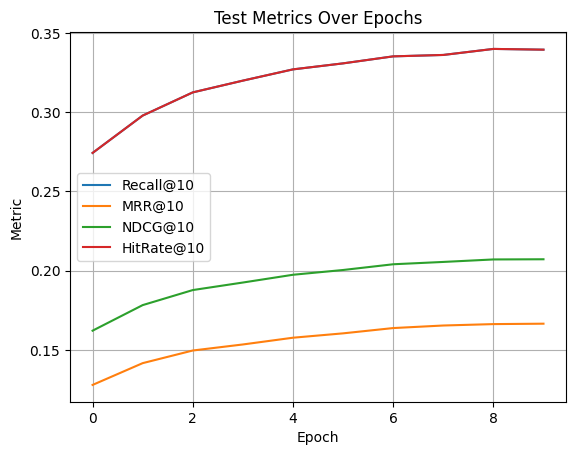

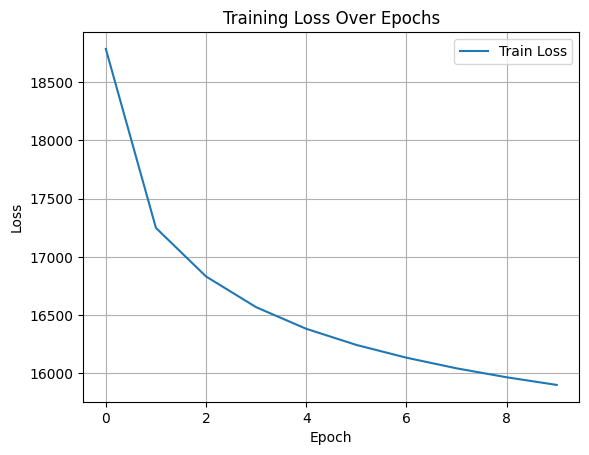


Total run time: 273.11 minutes

--------------------
Output Section 7: Sample Predictions

User ID: 3
Input sequence:
  - Item 4913: Goodbye Girl, The (1977)
  - Item 3137: Family Thing, A (1996)
  - Item 25: Willy Wonka & the Chocolate Factory (1971)
  - Item 1297: Nutty Professor, The (1963)
  - Item 3222: Ruthless People (1986)
  - Item 1028: Waiting to Exhale (1995)
  - Item 2122: Charade (1963)
  - Item 1094: You've Got Mail (1998)
  - Item 1307: Breakfast Club, The (1985)
  - Item 2676: My Man Godfrey (1957)
  - Item 1355: Emma (1996)
  - Item 209: Men in Black (1997)
  - Item 864: South Park: Bigger, Longer and Uncut (1999)
  - Item 88: Ghost (1990)
  - Item 298: Airplane! (1980)
  - Item 98: Birdcage, The (1996)
  - Item 947: Grease (1978)
  - Item 2139: Tea with Mussolini (1999)
  - Item 1181: League of Their Own, A (1992)
  - Item 664: Made in America (1993)
  - Item 1312: Liar Liar (1997)
  - Item 1697: Renaissance Man (1994)
  - Item 932: Splash (1984)
  - Item 1449: With 

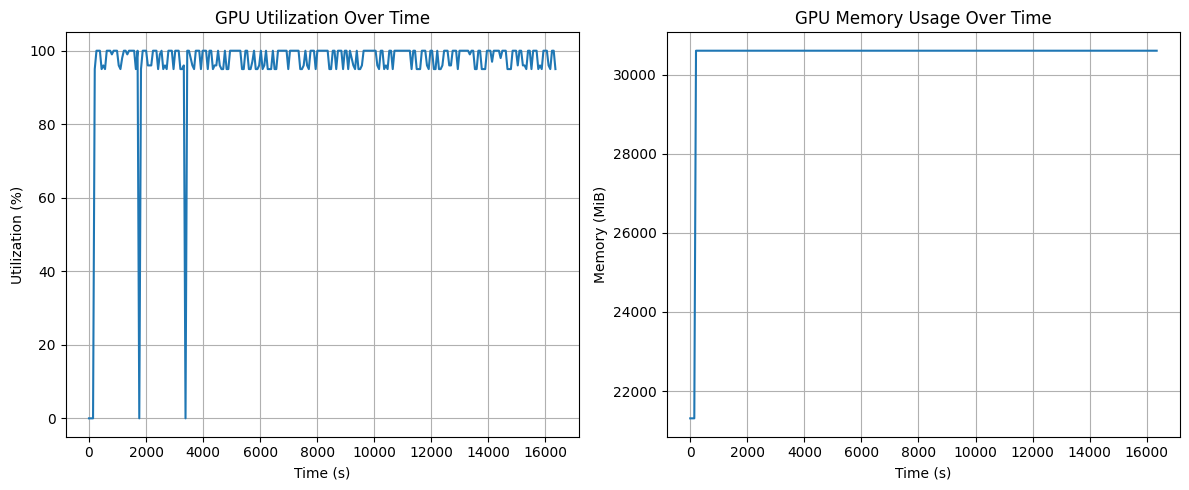


 Loading best model from: best_model_10M_BERT4Rec_SL:100_Emb:256.pt 10MBERT4Rec
Completed


In [20]:
recommender_main()

In [21]:
# import time
# time.sleep(60)

In [22]:
# MOVIELENS_VERSION = "10M"  # Choose from "100K","1M","10M","20M"
# MODEL_SELECTION = "SAS4Rec"  # "LSTM", "xLSTM", "BERT4Rec", "SAS4Rec"
# EPOCHS = 10
# MAX_LEN = 100

# recommender_main()

# #early stopping
# patience = 3
# # Run the Main Script after selection

In [23]:
# MOVIELENS_VERSION = "100K"  # Choose from "100K","1M","10M","20M"
# MODEL_SELECTION = "xLSTM"  # "LSTM", "xLSTM", "BERT4Rec", "SAS4Rec"
# EPOCHS = 20
# MAX_LEN = 50

# recommender_main()

# #early stopping
# patience = 3
# # Run the Main Script after selection

In [24]:
# MOVIELENS_VERSION = "100K"  # Choose from "100K","1M","10M","20M"
# MODEL_SELECTION = "BERT4Rec"  # "LSTM", "xLSTM", "BERT4Rec", "SAS4Rec"
# EPOCHS = 20
# MAX_LEN = 100

# recommender_main()

# #early stopping
# patience = 3
# # Run the Main Script after selection

In [25]:
# MOVIELENS_VERSION = "100K"  # Choose from "100K","1M","10M","20M"
# MODEL_SELECTION = "BERT4Rec"  # "LSTM", "xLSTM", "BERT4Rec", "SAS4Rec"
# EPOCHS = 20
# MAX_LEN = 75

# recommender_main()

# #early stopping
# patience = 3
# # Run the Main Script after selection

In [26]:
# MOVIELENS_VERSION = "100K"  # Choose from "100K","1M","10M","20M"
# MODEL_SELECTION = "BERT4Rec"  # "LSTM", "xLSTM", "BERT4Rec", "SAS4Rec"
# EPOCHS = 20
# MAX_LEN = 50

# recommender_main()

# #early stopping
# patience = 3
# # Run the Main Script after selection

In [27]:
# MOVIELENS_VERSION = "100K"  # Choose from "100K","1M","10M","20M"
# MODEL_SELECTION = "SAS4Rec"  # "LSTM", "xLSTM", "BERT4Rec", "SAS4Rec"
# EPOCHS = 20
# MAX_LEN = 100

# recommender_main()

# #early stopping
# patience = 3
# # Run the Main Script after selection

In [28]:
# MOVIELENS_VERSION = "100K"  # Choose from "100K","1M","10M","20M"
# MODEL_SELECTION = "SAS4Rec"  # "LSTM", "xLSTM", "BERT4Rec", "SAS4Rec"
# EPOCHS = 20
# MAX_LEN = 75

# recommender_main()

# #early stopping
# patience = 3
# # Run the Main Script after selection

In [29]:
# MOVIELENS_VERSION = "100K"  # Choose from "100K","1M","10M","20M"
# MODEL_SELECTION = "SAS4Rec"  # "LSTM", "xLSTM", "BERT4Rec", "SAS4Rec"
# EPOCHS = 20
# MAX_LEN = 50

# recommender_main()

# #early stopping
# patience = 3
# # Run the Main Script after selection

Main Script

In [31]:
# time.sleep(60)

In [ ]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs/

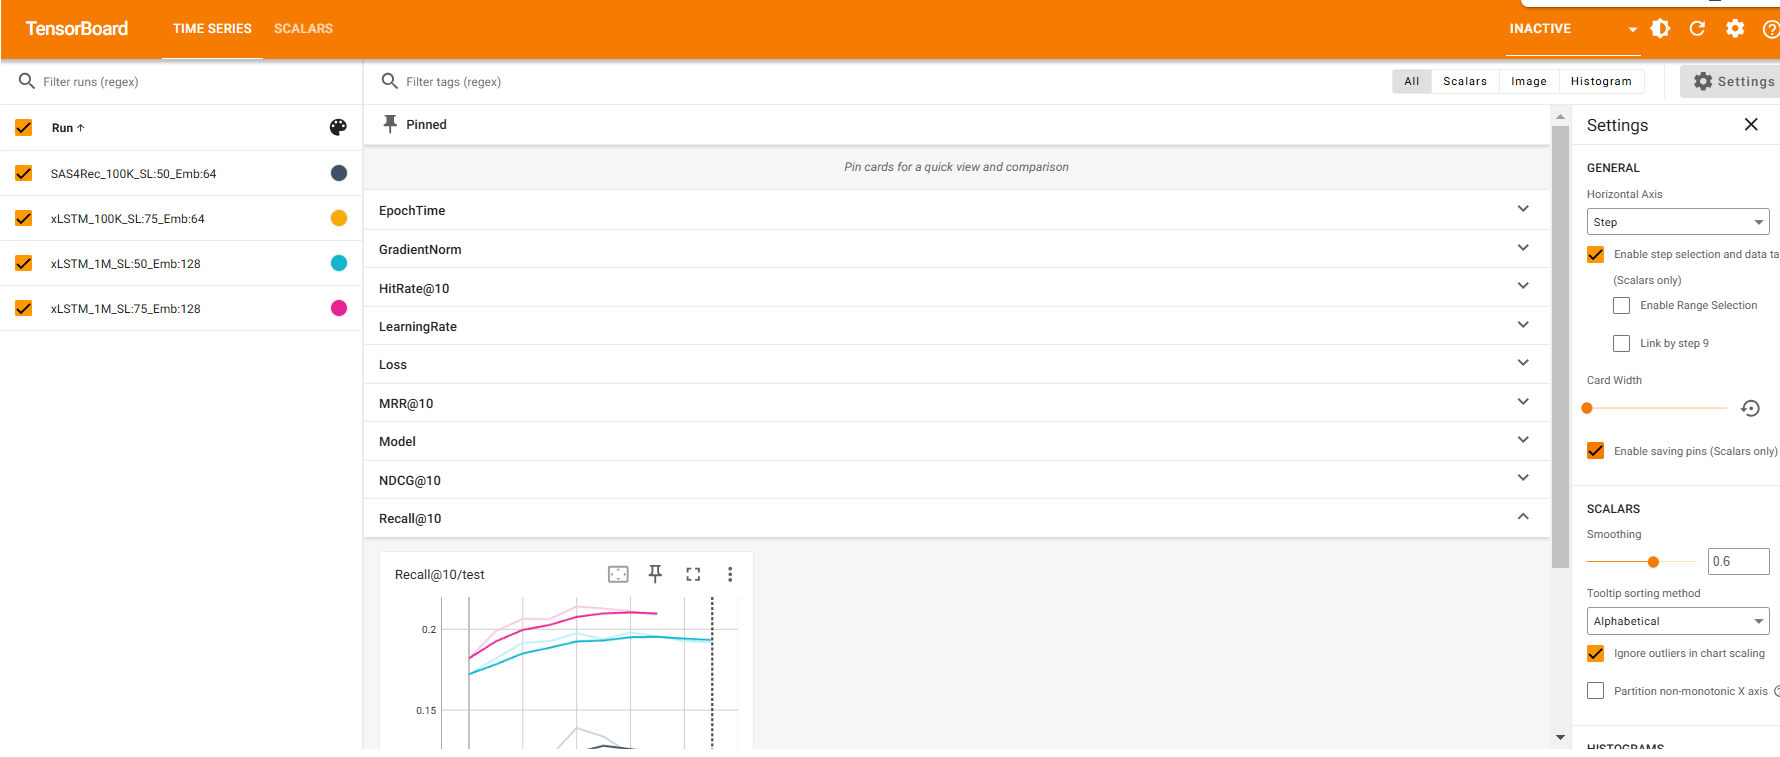